In [141]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import pandas as pd
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results'))
OUTPUT_PATH = os.path.abspath(os.path.join(os.getcwd(), 'figures'))

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [142]:
# Adapted from https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
sns.set(font='Helvetica',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'axes.axisbelow': True,
 'grid.color': 'lightgrey',
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":16,
                                "axes.labelsize":13})

In [3]:
def parse_json(path):
    data = {}
    for f in os.listdir(path):
        lambda_no = 1
        has_multiple_lambda = False
        matches_multiple_lambda = re.search(r"(producer|consumer)_(\d+)_(\d+)_(\d+).json", f)
        if matches_multiple_lambda:
            lambda_no = int(matches_multiple_lambda.group(4))
            has_multiple_lambda = True
            matches = matches_multiple_lambda
        else:
            matches = re.search(r"(producer|consumer)_(\d+)_(\d+).json", f)
        if matches:
            run_type, file_size, run = matches.group(1), int(matches.group(2)), int(matches.group(3))
            if run_type not in data:
                data[run_type] = {}
            if file_size not in data[run_type]:
                data[run_type][file_size] = {}
            if has_multiple_lambda and run not in data[run_type][file_size]:
                data[run_type][file_size][run] = {}
            with open(os.path.join(path, f)) as file_p:
                json_data = json.load(file_p)
                if has_multiple_lambda:
                    data[run_type][file_size][run][lambda_no] = json_data
                else:
                    data[run_type][file_size][run] = json_data
    return data

def calc_deltas(data):
    deltas = {}
    for file_size, runs in data['consumer'].items():
        deltas[file_size] = {}
        for run_number, run_data in runs.items():
            if 'finishedTime' in run_data: # single lambda
                if int(np.log10(run_data['finishedTime'])) == 15:
                    # Convert to ms
                    run_data['finishedTime'] /= 1000
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                if run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime'] < 0.1:
                    deltas[file_size][run_number] = 0.1
                else:
                    deltas[file_size][run_number] = run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime']
                
            else:
                all_finished_times = [lambda_run['finishedTime'] for lambda_run in run_data.values()]
                if int(np.log10(data['producer'][file_size][run_number]['uploadTime'])) == 15:
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                    all_finished_times = [v / 1000 for v in all_finished_times]
                all_deltas = []
                for fin_time in all_finished_times:
                    if fin_time - data['producer'][file_size][run_number]['uploadTime'] < 0:
                        all_deltas.append(0.1)
                    else:
                        all_deltas.append(fin_time - data['producer'][file_size][run_number]['uploadTime'])

                deltas[file_size][run_number] = all_deltas
    return deltas

In [4]:
def format_xticks(label_values):
    xticks = []
    for val in label_values:
        if val == 10000:
            xticks.append("10⁴")
        elif val == 100000:
            xticks.append("10⁵")
        elif val == 500000:
            xticks.append("5·10⁵")
        elif val >= 1:
            xticks.append(str(int(val)))
        else:
            xticks.append(str(val))
    return xticks

## Data

In [5]:
MPI_BASE_BATH = os.path.join(BASE_PATH, 'mpi', 'res')
SMI_BASE_BATH = os.path.join(BASE_PATH, 'smi', 'res')
NUM_NODES = [2, 4, 8, 16, 32]
experiments = ['allreduce', 'bcast', 'gather', 'reduce', 'scan', 'scatter']

In [6]:
vals = {}
for experiment in experiments:
    print(experiment)
    data = {"n": [], "latency": [], "method": []}
    for num_node in NUM_NODES:
        mpi_path = os.path.join(MPI_BASE_BATH, "{}_{}.txt".format(experiment, num_node))
        smi_path = os.path.join(SMI_BASE_BATH, "{}_{}.txt".format(experiment, num_node))
        res_rounds = {}
        start_times = {}
        with open(mpi_path) as mpi_file:
            lines = mpi_file.readlines()
            for line in lines:
                parts = line.rstrip().split(",")
                peer_id = int(parts[0])
                exchange_num = int(parts[1])
                val = int(parts[2])
                if peer_id == 0:
                    start_times[exchange_num] = val
                else:
                    if exchange_num not in res_rounds:
                        res_rounds[exchange_num] = [val]
                    else:
                        res_rounds[exchange_num].append(val)
        for exchange_num, values in res_rounds.items():
            data["n"].append(num_node)
            if experiment == "gather":
                data["latency"].append(start_times[exchange_num] - min(values))
            else:
                data["latency"].append(max(values) - start_times[exchange_num])
            data["method"].append("Open MPI")
        res_rounds = {}
        start_times = {}
        with open(smi_path) as smi_file:
            lines = smi_file.readlines()
            for line in lines:
                parts = line.rstrip().split(",")
                peer_id = int(parts[0])
                exchange_num = int(parts[1])
                val = int(parts[2])
                if peer_id == 0:
                    start_times[exchange_num] = val
                else:
                    if exchange_num not in res_rounds:
                        res_rounds[exchange_num] = [val]
                    else:
                        res_rounds[exchange_num].append(val)
        for exchange_num, values in res_rounds.items():
            data["n"].append(num_node)
            if experiment == "gather":
                data["latency"].append(start_times[exchange_num] - min(values))
            else:
                data["latency"].append(max(values) - start_times[exchange_num])            
            data["method"].append("FMI")
    vals[experiment] = pd.DataFrame(data)

display(vals["allreduce"].groupby(['n', 'method']).max())
display(vals["bcast"].groupby(['n', 'method']).max())
display(vals["gather"].groupby(['n', 'method']).max())
display(vals["reduce"].groupby(['n', 'method']).max())
display(vals["scan"].groupby(['n', 'method']).max())
display(vals["scatter"].groupby(['n', 'method']).max())
mpi_bench = vals

allreduce
bcast
gather
reduce
scan
scatter


latency
n  method           
2  FMI          2282
   Open MPI      801
4  FMI          2554
   Open MPI      788
8  FMI          5443
   Open MPI     1586
16 FMI          6261
   Open MPI     2316
32 FMI          8683
   Open MPI     2387

latency
n  method           
2  FMI           964
   Open MPI      264
4  FMI          2125
   Open MPI      590
8  FMI           953
   Open MPI     6339
16 FMI          3065
   Open MPI     1835
32 FMI          5619
   Open MPI     5610

latency
n  method           
2  FMI           646
   Open MPI      947
4  FMI          2014
   Open MPI     1282
8  FMI          1702
   Open MPI     2525
16 FMI          4401
   Open MPI     3162
32 FMI          6261
   Open MPI     6370

latency
n  method           
2  FMI          1859
   Open MPI     2414
4  FMI          1644
   Open MPI      807
8  FMI          2241
   Open MPI      753
16 FMI          1753
   Open MPI     4026
32 FMI         10550
   Open MPI     3610

latency
n  method           
2  FMI          1847
   Open MPI      227
4  FMI          1997
   Open MPI      566
8  FMI          5909
   Open MPI     1702
16 FMI          3478
   Open MPI     6125
32 FMI          8773
   Open MPI    10546

latency
n  method           
2  FMI          1583
   Open MPI     1189
4  FMI          1134
   Open MPI      997
8  FMI          2144
   Open MPI     1441
16 FMI          5037
   Open MPI     2729
32 FMI          2521
   Open MPI     2909

'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


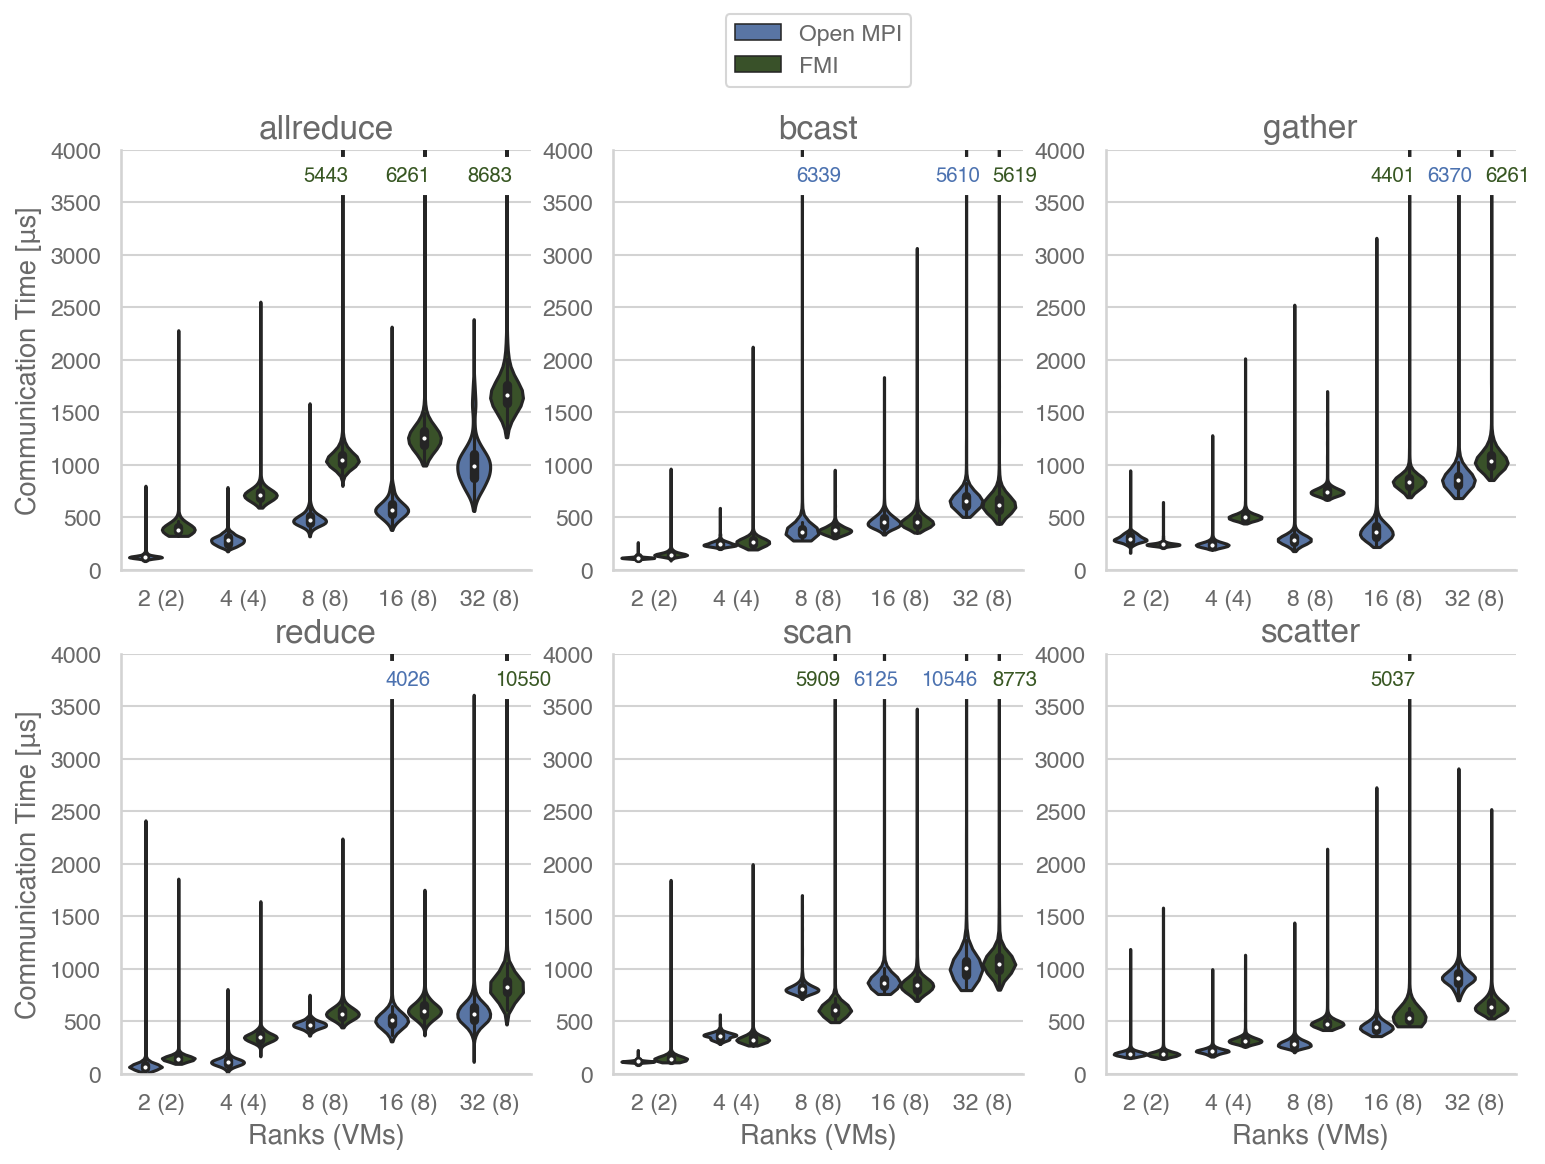

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
my_pal = {"Open MPI": "b", "FMI": "#385723"}
axs[0,0].set_ylim(0,4000)
axs[0,0].set_title("allreduce")
axs[0,1].set_ylim(0,4000)
axs[0,1].set_title("bcast")
axs[0,2].set_ylim(0,4000)
axs[0,2].set_title("gather")
axs[1,0].set_ylim(0,4000)
axs[1,0].set_title("reduce")
axs[1,1].set_ylim(0,4000)
axs[1,1].set_title("scan")
axs[1,2].set_ylim(0,4000)
axs[1,2].set_title("scatter")

sns.violinplot(x="n", y="latency", hue="method", data=vals["allreduce"], ax=axs[0, 0], cut=0, palette=my_pal, scale="count")
sns.violinplot(x="n", y="latency", hue="method", data=vals["bcast"], ax=axs[0, 1], cut=0, palette=my_pal, scale="count")
sns.violinplot(x="n", y="latency", hue="method", data=vals["gather"], ax=axs[0, 2], cut=0, palette=my_pal, scale="count")
sns.violinplot(x="n", y="latency", hue="method", data=vals["reduce"], ax=axs[1, 0], cut=0, palette=my_pal, scale="count")
sns.violinplot(x="n", y="latency", hue="method", data=vals["scan"], ax=axs[1, 1], cut=0, palette=my_pal, scale="count")
sns.violinplot(x="n", y="latency", hue="method", data=vals["scatter"], ax=axs[1, 2], cut=0, palette=my_pal, scale="count")

for ix,iy in np.ndindex(axs.shape):
    axs[ix,iy].set_xticklabels(["2 (2)", "4 (4)", "8 (8)", "16 (8)", "32 (8)"])
    if ix == 0 and iy == 1:
        axs[ix,iy].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fancybox=True)
    else:
        axs[ix,iy].legend([],[], frameon=False)
    if ix == 1:
        axs[ix,iy].set_xlabel("Ranks (VMs)")
    else:
        axs[ix,iy].set_xlabel(None)
    if iy == 0:
        axs[ix,iy].set_ylabel("Communication Time [μs]")
    else:
        axs[ix,iy].set_ylabel(None)

axs[0,0].text(2, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["allreduce"][(vals["allreduce"]["n"] == 8) & (vals["allreduce"]["method"] == "FMI")]["latency"].max())
axs[0,0].text(3, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["allreduce"][(vals["allreduce"]["n"] == 16) & (vals["allreduce"]["method"] == "FMI")]["latency"].max())
axs[0,0].text(4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["allreduce"][(vals["allreduce"]["n"] == 32) & (vals["allreduce"]["method"] == "FMI")]["latency"].max())

axs[0,1].text(4.4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["bcast"][(vals["bcast"]["n"] == 32) & (vals["bcast"]["method"] == "FMI")]["latency"].max())
axs[0,1].text(2, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["bcast"][(vals["bcast"]["n"] == 8) & (vals["bcast"]["method"] == "Open MPI")]["latency"].max())
axs[0,1].text(3.7, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["bcast"][(vals["bcast"]["n"] == 32) & (vals["bcast"]["method"] == "Open MPI")]["latency"].max())

axs[0,2].text(3, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["gather"][(vals["gather"]["n"] == 16) & (vals["gather"]["method"] == "FMI")]["latency"].max())
axs[0,2].text(4.4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["gather"][(vals["gather"]["n"] == 32) & (vals["gather"]["method"] == "FMI")]["latency"].max())
axs[0,2].text(3.7, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["gather"][(vals["gather"]["n"] == 32) & (vals["gather"]["method"] == "Open MPI")]["latency"].max())

axs[1,0].text(3, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["reduce"][(vals["reduce"]["n"] == 16) & (vals["reduce"]["method"] == "Open MPI")]["latency"].max())
axs[1,0].text(4.4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["reduce"][(vals["reduce"]["n"] == 32) & (vals["reduce"]["method"] == "FMI")]["latency"].max())

axs[1,1].text(2.7, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["scan"][(vals["scan"]["n"] == 16) & (vals["scan"]["method"] == "Open MPI")]["latency"].max())
axs[1,1].text(3.6, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["scan"][(vals["scan"]["n"] == 32) & (vals["scan"]["method"] == "Open MPI")]["latency"].max())
axs[1,1].text(2, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["scan"][(vals["scan"]["n"] == 8) & (vals["scan"]["method"] == "FMI")]["latency"].max())
axs[1,1].text(4.4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["scan"][(vals["scan"]["n"] == 32) & (vals["scan"]["method"] == "FMI")]["latency"].max())

axs[1,2].text(3, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["scatter"][(vals["scatter"]["n"] == 16) & (vals["scatter"]["method"] == "FMI")]["latency"].max())

fig.savefig(os.path.join(OUTPUT_PATH, "fmi_benchmark_mpi.pdf"), bbox_inches='tight')


## Merged Figure

In [9]:
DIRECT_BASE_PATH = os.path.join(BASE_PATH, 'smi', 'out_lambda_direct')
REDIS_BASE_BATH = os.path.join(BASE_PATH, 'smi', 'out_lambda_redis')
S3_BASE_BATH = os.path.join(BASE_PATH, 'smi', 'out_lambda_s3')
experiments = ['allreduce', 'bcast', 'gather', 'reduce', 'scan', 'scatter']

vals = {}
NUM_NODES = [2, 4, 8, 16, 32, 64, 128, 256]
for experiment in experiments:
    data = {"n": [], "latency": [], "method": []}
    for num_node in NUM_NODES:
        for base_path, channel in [(DIRECT_BASE_PATH, "Direct"), (REDIS_BASE_BATH, "Redis"), (S3_BASE_BATH, "S3")]:
            if num_node > 32 and channel == "S3":
                continue
            if num_node > 64 and channel == "Redis":
                continue
            res_rounds = {}
            start_times = {}
            for i in range(num_node):
                path = os.path.join(base_path, "{}_{}_{}.json".format(experiment, num_node, i))
                with open(path) as file:
                    lines = file.readlines()
                    for line in lines:
                        parts = line.rstrip().split(",")
                        peer_id = int(parts[0])
                        exchange_num = int(parts[1])
                        val = int(parts[2])
                        if peer_id == 0:
                            start_times[exchange_num] = val
                        else:
                            if exchange_num not in res_rounds:
                                res_rounds[exchange_num] = [val]
                            else:
                                res_rounds[exchange_num].append(val)
            for exchange_num, values in res_rounds.items():
                data["n"].append(num_node)
                if experiment == "gather":
                    data["latency"].append(start_times[exchange_num] - min(values))
                else:
                    data["latency"].append(max(values) - start_times[exchange_num])
                data["method"].append(channel)
        vals[experiment] = pd.DataFrame(data)

for experiment in experiments:
    print(experiment)
    display(vals[experiment].groupby(['n', 'method']).mean())
lambda_bench = vals

allreduce


latency
n   method               
2   Direct    1040.533333
    Redis     4645.100000
    S3      108971.800000
4   Direct    2323.066667
    Redis     8236.733333
    S3      156254.700000
8   Direct    3995.766667
    Redis    12021.733333
    S3      285996.700000
16  Direct    5022.800000
    Redis    27981.633333
    S3      369697.400000
32  Direct   10028.900000
    Redis    51662.566667
    S3      600348.600000
64  Direct   11236.866667
    Redis   230199.333333
128 Direct   22931.033333
256 Direct   53593.300000

bcast


latency
n   method              
2   Direct    998.200000
    Redis    1911.600000
    S3      42280.400000
4   Direct    778.466667
    Redis    2735.133333
    S3      49379.600000
8   Direct   1028.500000
    Redis    2823.900000
    S3      67196.900000
16  Direct   2632.400000
    Redis    4125.833333
    S3      59371.900000
32  Direct   3220.166667
    Redis   12316.466667
    S3      95567.000000
64  Direct   4896.966667
    Redis   40465.900000
128 Direct   8306.700000
256 Direct  26570.733333

gather


latency
n   method               
2   Direct     719.800000
    Redis     1987.433333
    S3       56301.000000
4   Direct    1185.033333
    Redis     4425.533333
    S3       99532.700000
8   Direct    2460.566667
    Redis    10478.233333
    S3      178098.100000
16  Direct    3151.433333
    Redis    17681.900000
    S3      380872.600000
32  Direct    4949.933333
    Redis    39745.400000
    S3      598314.500000
64  Direct   11728.600000
    Redis   147251.600000
128 Direct    9366.133333
256 Direct   20237.166667

reduce


latency
n   method               
2   Direct     495.500000
    Redis     1781.566667
    S3       36746.400000
4   Direct     979.100000
    Redis     1786.466667
    S3       32523.500000
8   Direct    2050.133333
    Redis     3217.400000
    S3       46436.500000
16  Direct    3461.433333
    Redis     6889.033333
    S3       60714.900000
32  Direct    6494.266667
    Redis    25463.566667
    S3      105501.400000
64  Direct    6451.100000
    Redis    40859.966667
128 Direct    9404.133333
256 Direct   16532.900000

scan


latency
n   method               
2   Direct     757.666667
    Redis     3168.333333
    S3       61062.100000
4   Direct    1062.466667
    Redis     5195.933333
    S3      112032.400000
8   Direct    1509.266667
    Redis     9788.366667
    S3      168780.800000
16  Direct    3595.466667
    Redis    16778.400000
    S3      265502.100000
32  Direct    5369.200000
    Redis    40565.166667
    S3      513525.100000
64  Direct    8179.600000
    Redis   184719.200000
128 Direct   12221.000000
256 Direct   28415.533333

scatter


latency
n   method               
2   Direct     127.400000
    Redis     2402.333333
    S3       58608.500000
4   Direct     939.800000
    Redis     4393.766667
    S3      114011.400000
8   Direct    2007.533333
    Redis     8188.666667
    S3      276568.800000
16  Direct    3777.266667
    Redis    14803.966667
    S3      484673.800000
32  Direct    3712.066667
    Redis    36371.566667
    S3      922380.300000
64  Direct    7779.700000
    Redis   123478.600000
128 Direct   15899.200000
256 Direct   19221.333333

'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


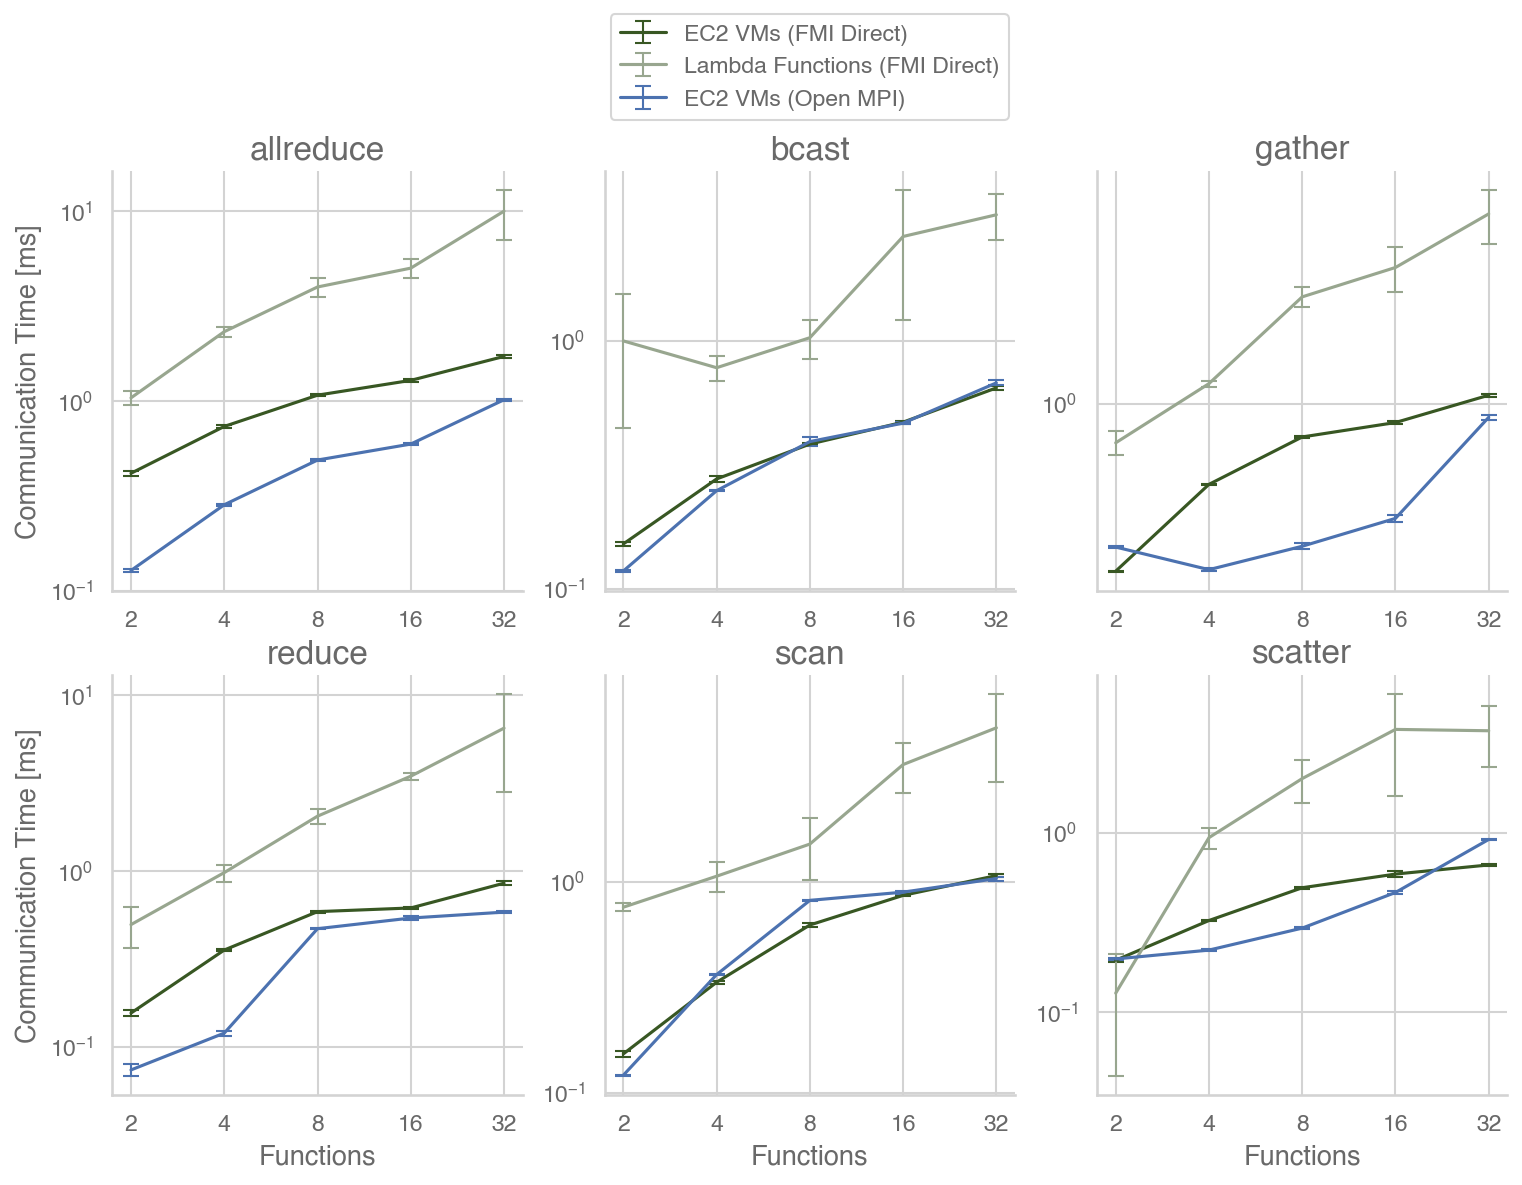

In [11]:
NUM_NODES = [2, 4, 8, 16, 32]
vals = {}
for experiment in experiments:
    vals[experiment] = pd.concat([mpi_bench[experiment][(mpi_bench[experiment]["method"] == "FMI") | (mpi_bench[experiment]["method"] == "Open MPI")], lambda_bench[experiment][lambda_bench[experiment]["method"] == "Direct"]])
    vals[experiment]["method"] = vals[experiment]["method"].replace({"FMI": "EC2 VMs (FMI Direct)", "Open MPI": "EC2 VMs (Open MPI)", "Direct": "Lambda Functions (FMI Direct)"})
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
my_pal = {
    "EC2 VMs (FMI Direct)": "#385723", 
    "Lambda Functions (FMI Direct)": "#98a68f", 
    "EC2 VMs (Open MPI)": "b"
}
for method in ["EC2 VMs (FMI Direct)", "Lambda Functions (FMI Direct)", "EC2 VMs (Open MPI)"]:
    ix, iy = 0, 0
    for experiment in experiments:
        plot_data = {}
        error = []
        preds = {}
        for num_node in NUM_NODES:
            experiment_sizes = {
                "allreduce": 4,
                "bcast": 4,
                "gather": 4992 / num_node,
                "reduce": 4,
                "scan": 4,
                "scatter": 4992 / num_node
            }
            values = vals[experiment].loc[(vals[experiment]['n'] == num_node) & (vals[experiment]['method'] == method)]['latency']
            mean = np.mean(values)
            ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
            plot_data[num_node] = mean / 1000
            error.append(ci / 1000)
        axs[ix,iy].errorbar(plot_data.keys(), plot_data.values(), error, elinewidth=1, capsize=4, label=method, c=my_pal[method])
        axs[ix,iy].set_title(experiment)
        axs[ix,iy].set_yscale('log')
        axs[ix,iy].set_xscale('log')
        axs[ix,iy].set_xticks(NUM_NODES)
        axs[ix,iy].set_xticklabels(NUM_NODES)
        if ix == 0 and iy == 1:
            axs[ix,iy].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), fancybox=True)
        else:
            axs[ix,iy].legend([],[], frameon=False)
        if ix == 1:
            axs[ix,iy].set_xlabel("Functions")
        else:
            axs[ix,iy].set_xlabel(None)
        if iy == 0:
            axs[ix,iy].set_ylabel("Communication Time [ms]")
        else:
            axs[ix,iy].set_ylabel(None)
        iy += 1
        if iy > 2:
            iy = 0
            ix = 1
fig.savefig(os.path.join(OUTPUT_PATH, "fmi_mpi_lambda_benchmark_comparison.pdf"), bbox_inches='tight')

## New data

In [136]:
MPI_BASE_BATH = os.path.join(BASE_PATH, os.pardir, 'mpi', 'new_res')
SMI_BASE_BATH = os.path.join(BASE_PATH, os.pardir, 'fmi_vms', 'new_res')
NUM_NODES = [2, 4, 8, 16, 32]
experiments = ['allreduce', 'bcast', 'gather', 'reduce', 'scan', 'scatter']

In [127]:
mpi_data = []

for experiment in experiments:
    for num_node in NUM_NODES:
        
        dfs = []
        for rank in range(num_node):
                          
            mpi_path = os.path.join(MPI_BASE_BATH, f"{experiment}_{num_node}_{rank}.out")
            
            data = pd.read_csv(mpi_path, names=['start', 'end', 'duration'])[1:101]
            data.reset_index(inplace=True)
            dfs.append(data)
            #data['size'] = num_node
            #data['ranks'] = num_node
            #data['experiment'] = experiment
            #print(data)
        data = pd.concat(dfs)
        #print(data)
        max_data = data.groupby(['index'])['duration'].max().reset_index()
        max_data['ranks'] = num_node
        max_data['experiment'] = experiment
        #print(max_data)
        mpi_data.append(max_data)
        
mpi_data = pd.concat(mpi_data)
mpi_data["method"] = "Open MPI"

fmi_data = []

for experiment in experiments:
    for num_node in NUM_NODES:
        
        dfs = []
        for rank in range(num_node):
                          
            fmi_path = os.path.join(SMI_BASE_BATH, f"{experiment}_{num_node}_{rank}.out")
            
            data = pd.read_csv(fmi_path, names=['start', 'end', 'duration'])[1:101]
            data.reset_index(inplace=True)
            dfs.append(data)
            #data['size'] = num_node
            #data['ranks'] = num_node
            #data['experiment'] = experiment
            #print(data)
        data = pd.concat(dfs)
        #print(data)
        max_data = data.groupby(['index'])['duration'].max().reset_index()
        max_data['ranks'] = num_node
        max_data['experiment'] = experiment
        ##print(max_data)
        #print(max_data.min())
        #print(max_data.mean())
        #print(max_data.median())
        #print(max_data.quantile(.95))
        #print(max_data.quantile(.99))
        #print(max_data.max())
        fmi_data.append(max_data)
        
fmi_data = pd.concat(fmi_data)
fmi_data["method"] = "FMI"
mpi_data = pd.concat([fmi_data, mpi_data])
#print(mpi_data)
#display(vals["allreduce"].groupby(['n', 'method']).max())
#display(vals["bcast"].groupby(['n', 'method']).max())
#display(vals["gather"].groupby(['n', 'method']).max())
#display(vals["reduce"].groupby(['n', 'method']).max())
#display(vals["scan"].groupby(['n', 'method']).max())
#display(vals["scatter"].groupby(['n', 'method']).max())
#mpi_bench = vals

FileNotFoundError: [Errno 2] No such file or directory: '/work/serverless/2022/collectives/serverless-collectives-artifact/results/../fmi_vms/new_res/allreduce_2_0.out'

Text(2, 3750, '1235.5')

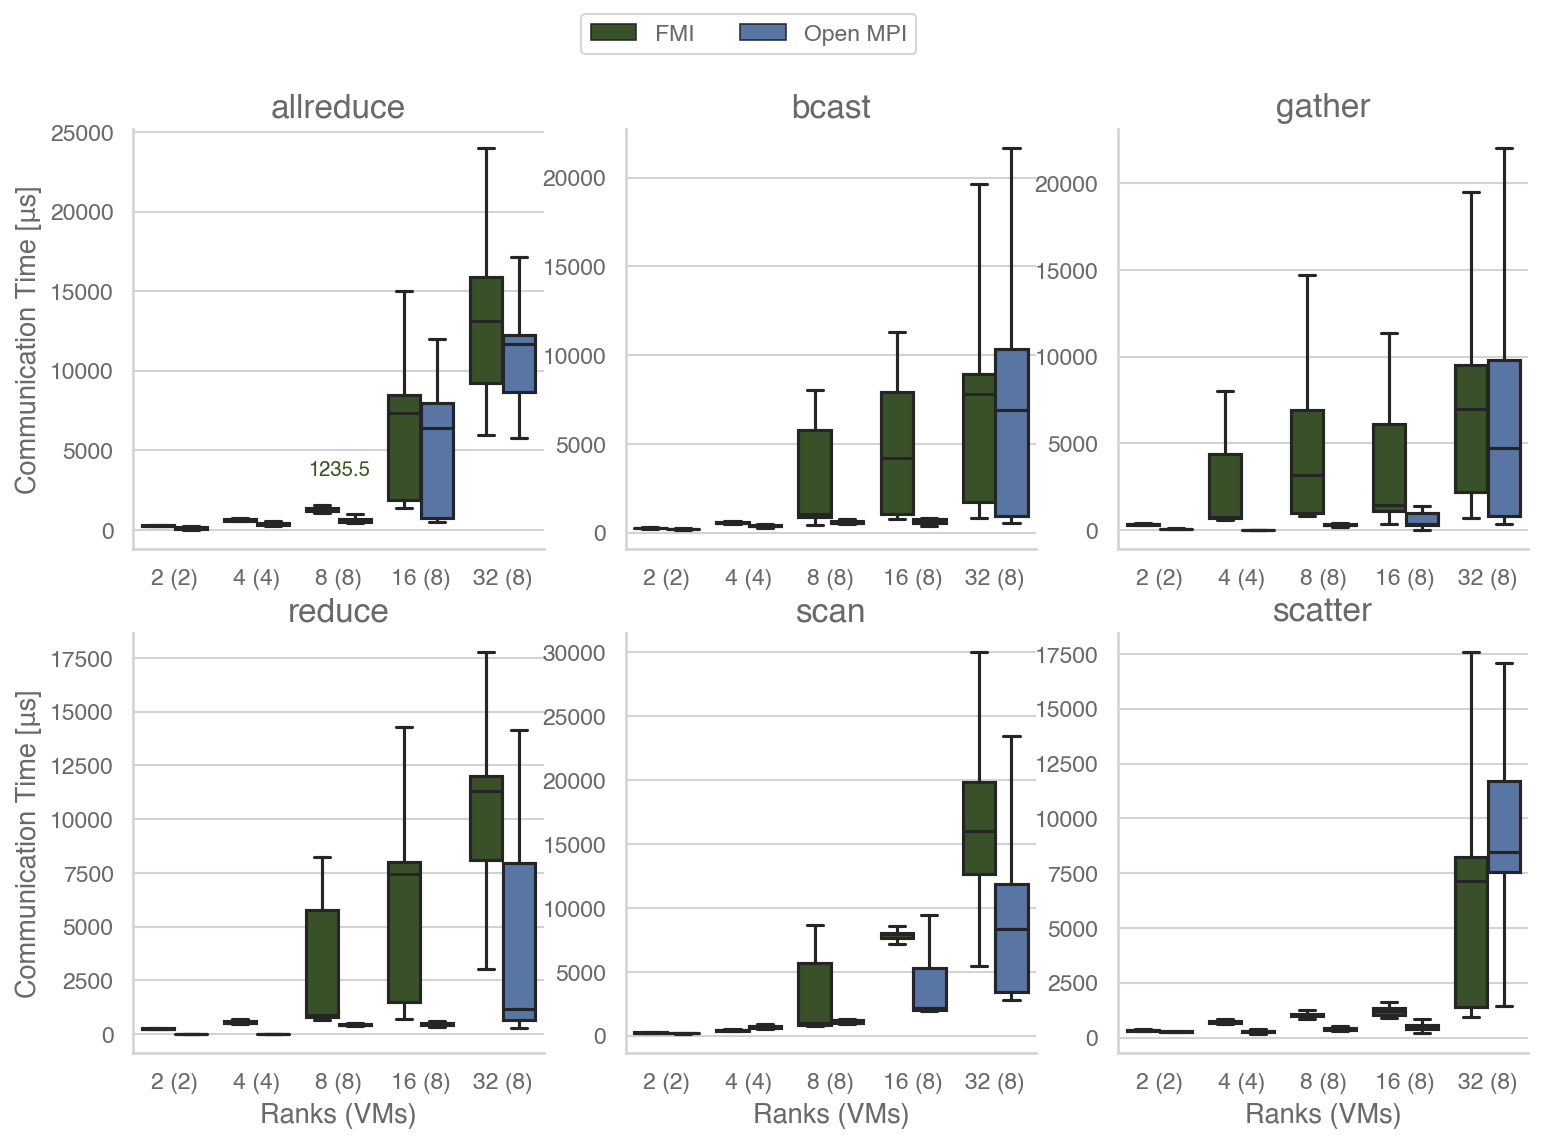

In [108]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
my_pal = {"Open MPI": "b", "FMI": "#385723"}
#axs[0,0].set_ylim(0,4000)
axs[0,0].set_title("allreduce")
#axs[0,1].set_ylim(0,4000)
axs[0,1].set_title("bcast")
#axs[0,2].set_ylim(0,4000)
axs[0,2].set_title("gather")
#axs[1,0].set_ylim(0,4000)
axs[1,0].set_title("reduce")
#axs[1,1].set_ylim(0,4000)
axs[1,1].set_title("scan")
#axs[1,2].set_ylim(0,4000)
axs[1,2].set_title("scatter")

sns.boxplot(x="ranks", y="duration", hue="method",
            data=data.loc[data['experiment'] == "allreduce"], ax=axs[0, 0], palette=my_pal,showfliers=False)
#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "allreduce"], ax=axs[0, 0], cut=0,palette=my_pal, scale="count")
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "bcast"], ax=axs[0, 1], palette=my_pal,showfliers=False)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "gather"], ax=axs[0, 2],palette=my_pal,showfliers=False)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "reduce"], ax=axs[1, 0], palette=my_pal,showfliers=False)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "scan"], ax=axs[1, 1], palette=my_pal,showfliers=False)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "scatter"], ax=axs[1, 2],  palette=my_pal,showfliers=False)


#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "allreduce"], ax=axs[0, 0], palette=my_pal, scale="width")
#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "bcast"], ax=axs[0, 1], cut=0, palette=my_pal, scale="count")
#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "gather"], ax=axs[0, 2], cut=0, palette=my_pal, scale="count")
#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "reduce"], ax=axs[1, 0], cut=0, palette=my_pal, scale="count")
#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "scan"], ax=axs[1, 1], cut=0, palette=my_pal, scale="count")
#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "scatter"], ax=axs[1, 2], cut=0, palette=my_pal, scale="count")


for ix,iy in np.ndindex(axs.shape):
    axs[ix,iy].set_xticklabels(["2 (2)", "4 (4)", "8 (8)", "16 (8)", "32 (8)"])
    if ix == 0 and iy == 1:
        axs[ix,iy].legend(loc='upper center', bbox_to_anchor=(0.3, 1.3), ncol=2, fancybox=True)
    else:
        axs[ix,iy].legend([],[], frameon=False)
    if ix == 1:
        axs[ix,iy].set_xlabel("Ranks (VMs)")
    else:
        axs[ix,iy].set_xlabel(None)
    if iy == 0:
        axs[ix,iy].set_ylabel("Communication Time [μs]")
    else:
        axs[ix,iy].set_ylabel(None)

axs[0,0].text(2, 3750, va='center', ha='center', size='x-small',
      backgroundcolor="white", color=my_pal["FMI"],
      s=data.loc[(data['experiment'] == "allreduce") & (data["ranks"] == 8) & (data["method"] == "FMI")]["duration"].median())

#axs[0,0].text(2, 3750, va='center', ha='center', size='x-small',
#              backgroundcolor="white", color=my_pal["FMI"],
#              s=data.loc[(data['experiment'] == "allreduce") & (data["ranks"] == 8) & (data["method"] == "FMI")]["duration"].max())
#axs[0,0].text(3, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["allreduce"][(vals["allreduce"]["n"] == 16) & (vals["allreduce"]["method"] == "FMI")]["latency"].max())
#axs[0,0].text(4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["allreduce"][(vals["allreduce"]["n"] == 32) & (vals["allreduce"]["method"] == "FMI")]["latency"].max())

#axs[0,1].text(4.4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["bcast"][(vals["bcast"]["n"] == 32) & (vals["bcast"]["method"] == "FMI")]["latency"].max())
#axs[0,1].text(2, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["bcast"][(vals["bcast"]["n"] == 8) & (vals["bcast"]["method"] == "Open MPI")]["latency"].max())
#axs[0,1].text(3.7, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["bcast"][(vals["bcast"]["n"] == 32) & (vals["bcast"]["method"] == "Open MPI")]["latency"].max())

#axs[0,2].text(3, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["gather"][(vals["gather"]["n"] == 16) & (vals["gather"]["method"] == "FMI")]["latency"].max())
#axs[0,2].text(4.4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["gather"][(vals["gather"]["n"] == 32) & (vals["gather"]["method"] == "FMI")]["latency"].max())
#axs[0,2].text(3.7, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["gather"][(vals["gather"]["n"] == 32) & (vals["gather"]["method"] == "Open MPI")]["latency"].max())

#axs[1,0].text(3, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["reduce"][(vals["reduce"]["n"] == 16) & (vals["reduce"]["method"] == "Open MPI")]["latency"].max())
#axs[1,0].text(4.4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["reduce"][(vals["reduce"]["n"] == 32) & (vals["reduce"]["method"] == "FMI")]["latency"].max())

#axs[1,1].text(2.7, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["scan"][(vals["scan"]["n"] == 16) & (vals["scan"]["method"] == "Open MPI")]["latency"].max())
#axs[1,1].text(3.6, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["scan"][(vals["scan"]["n"] == 32) & (vals["scan"]["method"] == "Open MPI")]["latency"].max())
#axs[1,1].text(2, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["scan"][(vals["scan"]["n"] == 8) & (vals["scan"]["method"] == "FMI")]["latency"].max())
#axs[1,1].text(4.4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["scan"][(vals["scan"]["n"] == 32) & (vals["scan"]["method"] == "FMI")]["latency"].max())

#axs[1,2].text(3, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["scatter"][(vals["scatter"]["n"] == 16) & (vals["scatter"]["method"] == "FMI")]["latency"].max())

#fig.savefig(os.path.join(OUTPUT_PATH, "fmi_benchmark_mpi_new.pdf"), bbox_inches='tight')


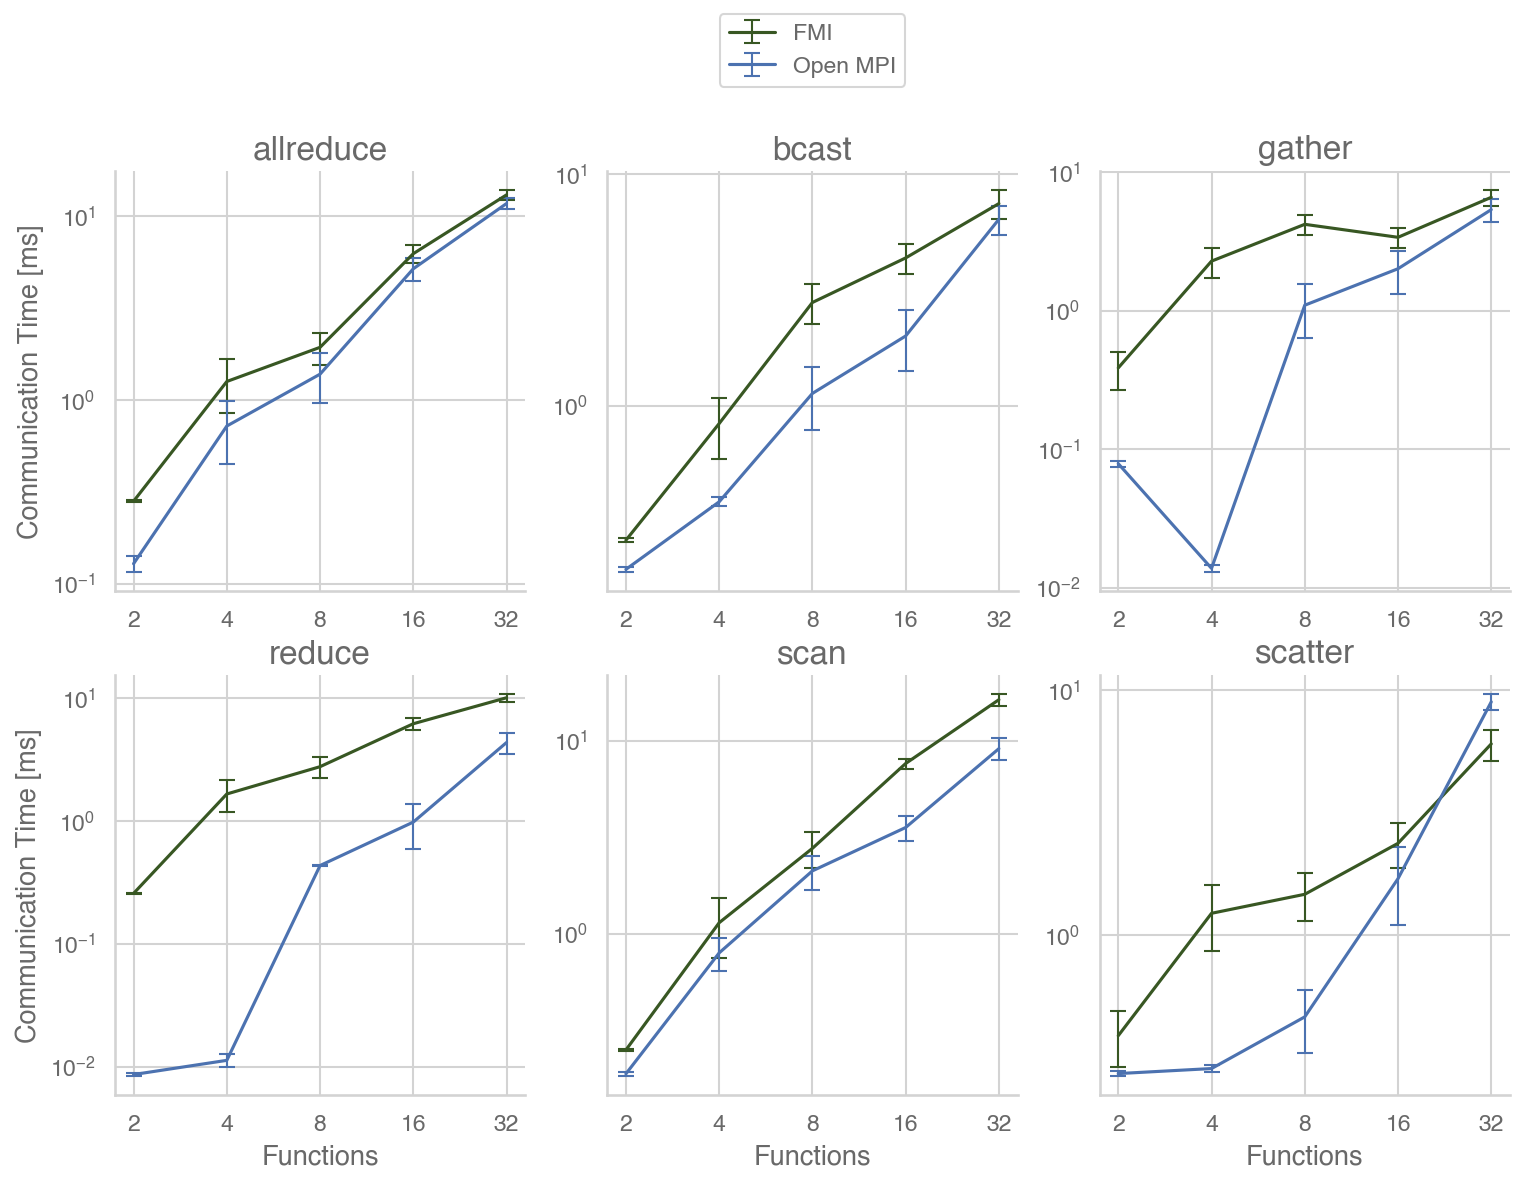

In [115]:
NUM_NODES = [2, 4, 8, 16, 32]
vals = {}
#for experiment in experiments:
#    vals[experiment] = pd.concat([mpi_bench[experiment][(mpi_bench[experiment]["method"] == "FMI") | (mpi_bench[experiment]["method"] == "Open MPI")], lambda_bench[experiment][lambda_bench[experiment]["method"] == "Direct"]])
#    vals[experiment]["method"] = vals[experiment]["method"].replace({"FMI": "EC2 VMs (FMI Direct)", "Open MPI": "EC2 VMs (Open MPI)", "Direct": "Lambda Functions (FMI Direct)"})
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
#my_pal = {
#    "EC2 VMs (FMI Direct)": "#385723", 
#    "Lambda Functions (FMI Direct)": "#98a68f", 
#    "EC2 VMs (Open MPI)": "b"
#}
my_pal = {
    "FMI": "#385723", 
    "Lambda Functions (FMI Direct)": "#98a68f", 
    "Open MPI": "b"
}
#for method in ["EC2 VMs (FMI Direct)", "Lambda Functions (FMI Direct)", "EC2 VMs (Open MPI)"]:
for method in ["FMI", "Open MPI"]:
    ix, iy = 0, 0
    for experiment in experiments:
        plot_data = {}
        error = []
        preds = {}
        for num_node in NUM_NODES:
            experiment_sizes = {
                "allreduce": 4,
                "bcast": 4,
                "gather": 4992 / num_node,
                "reduce": 4,
                "scan": 4,
                "scatter": 4992 / num_node
            }
            #values = vals[experiment].loc[(vals[experiment]['n'] == num_node) & (vals[experiment]['method'] == method)]['latency']
            values = data.loc[(data['experiment'] == experiment) & (data['ranks'] == num_node) & (data['method'] == method)]['duration']
            mean = np.mean(values)
            #mean = np.median(values)
            ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
            plot_data[num_node] = mean / 1000
            #print(mean, ci)
            error.append(ci / 1000)
            
            
        axs[ix,iy].errorbar(plot_data.keys(), plot_data.values(), error, elinewidth=1, capsize=4, label=method, c=my_pal[method])
        axs[ix,iy].set_title(experiment)
        axs[ix,iy].set_yscale('log')
        axs[ix,iy].set_xscale('log')
        axs[ix,iy].set_xticks(NUM_NODES)
        axs[ix,iy].set_xticklabels(NUM_NODES)
        if ix == 0 and iy == 1:
            axs[ix,iy].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), fancybox=True)
        else:
            axs[ix,iy].legend([],[], frameon=False)
        if ix == 1:
            axs[ix,iy].set_xlabel("Functions")
        else:
            axs[ix,iy].set_xlabel(None)
        if iy == 0:
            axs[ix,iy].set_ylabel("Communication Time [ms]")
        else:
            axs[ix,iy].set_ylabel(None)
        iy += 1
        if iy > 2:
            iy = 0
            ix = 1
#fig.savefig(os.path.join(OUTPUT_PATH, "fmi_mpi_lambda_benchmark_comparison.pdf"), bbox_inches='tight')

Text(2, 3750, '14638')

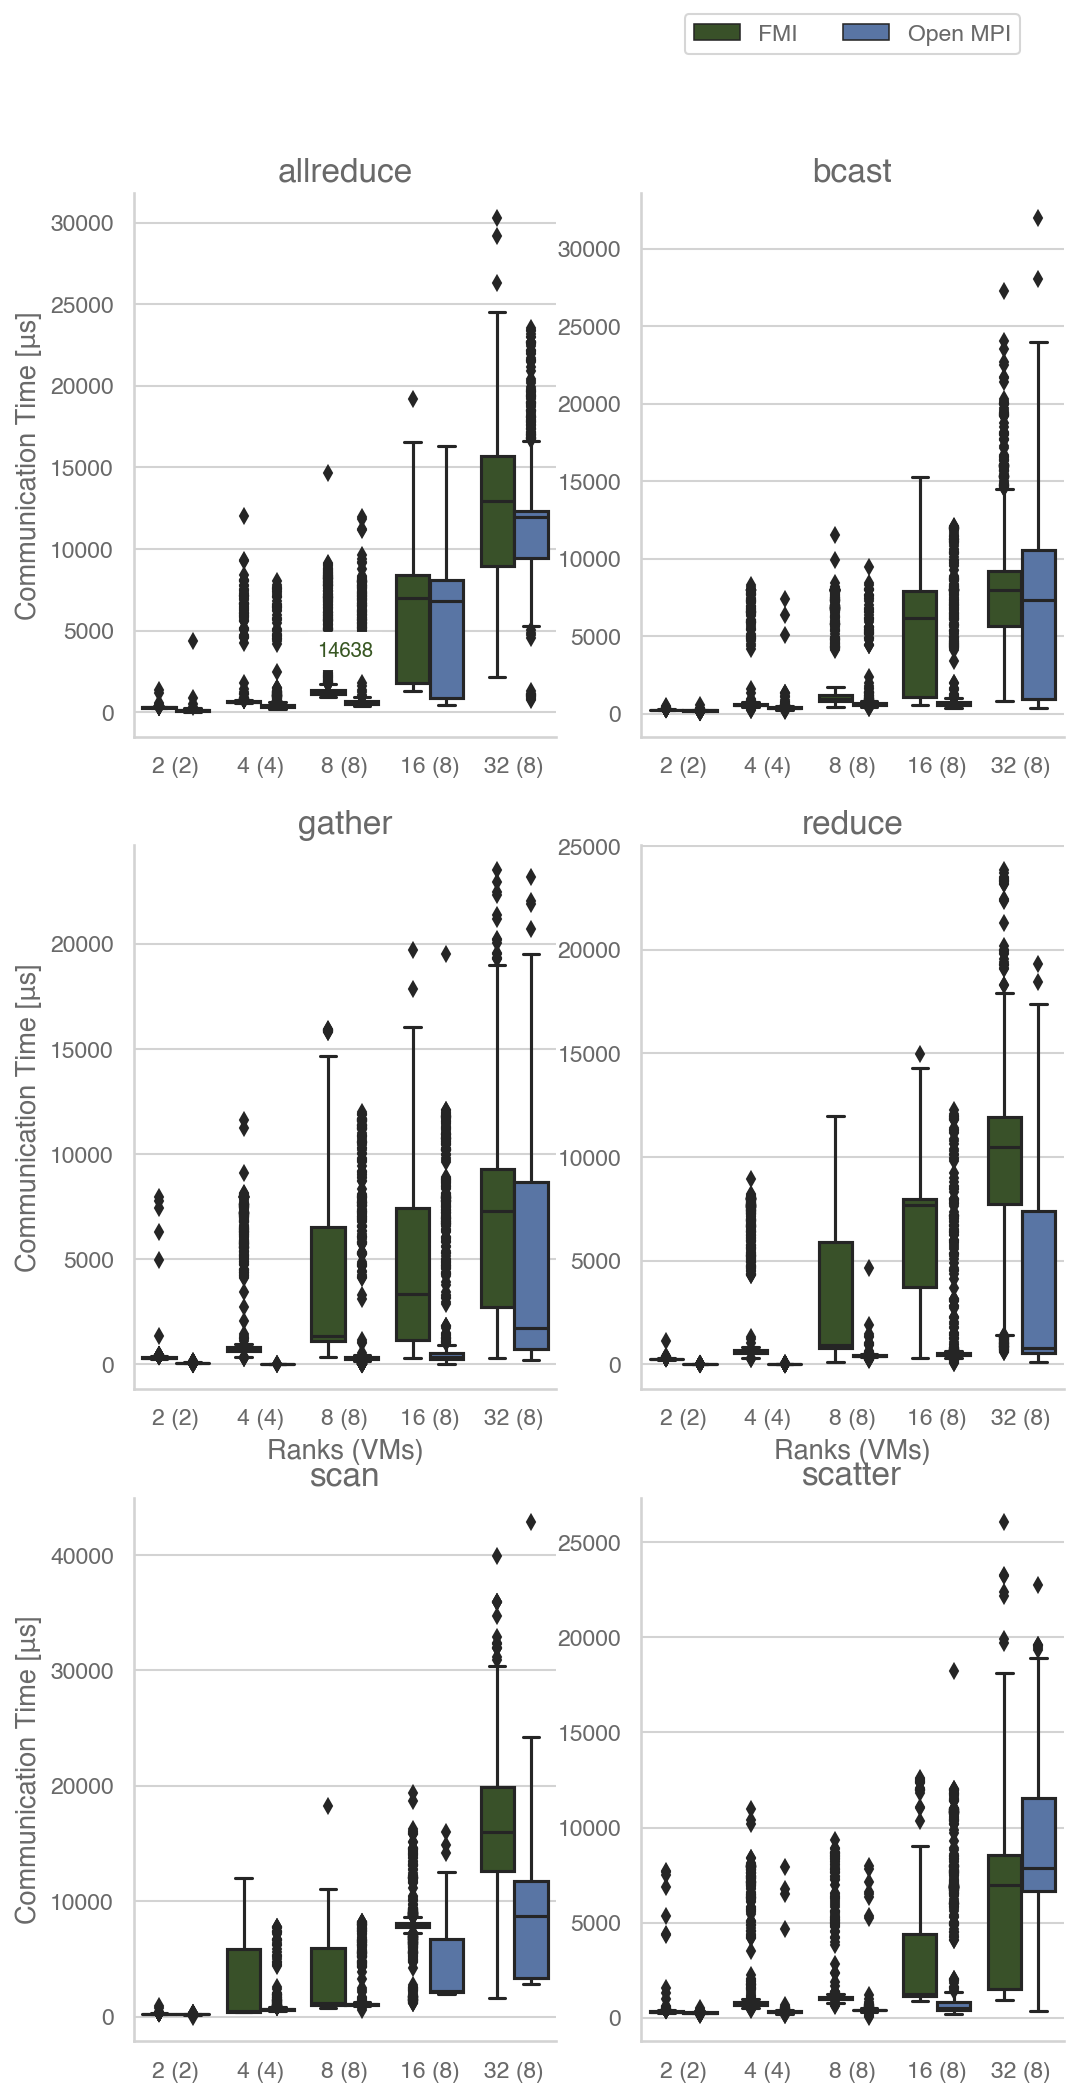

In [88]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 16))
my_pal = {"Open MPI": "b", "FMI": "#385723"}
#axs[0,0].set_ylim(0,4000)
axs[0,0].set_title("allreduce")
#axs[0,1].set_ylim(0,4000)
axs[0,1].set_title("bcast")
#axs[0,2].set_ylim(0,4000)
axs[1,0].set_title("gather")
#axs[1,0].set_ylim(0,4000)
axs[1,1].set_title("reduce")
#axs[1,1].set_ylim(0,4000)
axs[2,0].set_title("scan")
#axs[1,2].set_ylim(0,4000)
axs[2,1].set_title("scatter")

sns.boxplot(x="ranks", y="duration", hue="method",
            data=data.loc[data['experiment'] == "allreduce"], ax=axs[0, 0], palette=my_pal)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "bcast"], ax=axs[0, 1], palette=my_pal)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "gather"], ax=axs[1, 0],palette=my_pal)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "reduce"], ax=axs[1, 1], palette=my_pal)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "scan"], ax=axs[2, 0], palette=my_pal)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "scatter"], ax=axs[2, 1],  palette=my_pal)


#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "allreduce"], ax=axs[0, 0], palette=my_pal, scale="width")
#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "bcast"], ax=axs[0, 1], cut=0, palette=my_pal, scale="count")
#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "gather"], ax=axs[0, 2], cut=0, palette=my_pal, scale="count")
#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "reduce"], ax=axs[1, 0], cut=0, palette=my_pal, scale="count")
#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "scan"], ax=axs[1, 1], cut=0, palette=my_pal, scale="count")
#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "scatter"], ax=axs[1, 2], cut=0, palette=my_pal, scale="count")


for ix,iy in np.ndindex(axs.shape):
    axs[ix,iy].set_xticklabels(["2 (2)", "4 (4)", "8 (8)", "16 (8)", "32 (8)"])
    if ix == 0 and iy == 1:
        axs[ix,iy].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2, fancybox=True)
    else:
        axs[ix,iy].legend([],[], frameon=False)
    if ix == 1:
        axs[ix,iy].set_xlabel("Ranks (VMs)")
    else:
        axs[ix,iy].set_xlabel(None)
    if iy == 0:
        axs[ix,iy].set_ylabel("Communication Time [μs]")
    else:
        axs[ix,iy].set_ylabel(None)

axs[0,0].text(2, 3750, va='center', ha='center', size='x-small',
              backgroundcolor="white", color=my_pal["FMI"],
              s=data.loc[(data['experiment'] == "allreduce") & (data["ranks"] == 8) & (data["method"] == "FMI")]["duration"].max())
#axs[0,0].text(3, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["allreduce"][(vals["allreduce"]["n"] == 16) & (vals["allreduce"]["method"] == "FMI")]["latency"].max())
#axs[0,0].text(4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["allreduce"][(vals["allreduce"]["n"] == 32) & (vals["allreduce"]["method"] == "FMI")]["latency"].max())

#axs[0,1].text(4.4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["bcast"][(vals["bcast"]["n"] == 32) & (vals["bcast"]["method"] == "FMI")]["latency"].max())
#axs[0,1].text(2, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["bcast"][(vals["bcast"]["n"] == 8) & (vals["bcast"]["method"] == "Open MPI")]["latency"].max())
#axs[0,1].text(3.7, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["bcast"][(vals["bcast"]["n"] == 32) & (vals["bcast"]["method"] == "Open MPI")]["latency"].max())

#axs[0,2].text(3, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["gather"][(vals["gather"]["n"] == 16) & (vals["gather"]["method"] == "FMI")]["latency"].max())
#axs[0,2].text(4.4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["gather"][(vals["gather"]["n"] == 32) & (vals["gather"]["method"] == "FMI")]["latency"].max())
#axs[0,2].text(3.7, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["gather"][(vals["gather"]["n"] == 32) & (vals["gather"]["method"] == "Open MPI")]["latency"].max())

#axs[1,0].text(3, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["reduce"][(vals["reduce"]["n"] == 16) & (vals["reduce"]["method"] == "Open MPI")]["latency"].max())
#axs[1,0].text(4.4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["reduce"][(vals["reduce"]["n"] == 32) & (vals["reduce"]["method"] == "FMI")]["latency"].max())

#axs[1,1].text(2.7, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["scan"][(vals["scan"]["n"] == 16) & (vals["scan"]["method"] == "Open MPI")]["latency"].max())
#axs[1,1].text(3.6, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["Open MPI"], s=vals["scan"][(vals["scan"]["n"] == 32) & (vals["scan"]["method"] == "Open MPI")]["latency"].max())
#axs[1,1].text(2, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["scan"][(vals["scan"]["n"] == 8) & (vals["scan"]["method"] == "FMI")]["latency"].max())
#axs[1,1].text(4.4, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["scan"][(vals["scan"]["n"] == 32) & (vals["scan"]["method"] == "FMI")]["latency"].max())

#axs[1,2].text(3, 3750, va='center', ha='center', size='x-small', backgroundcolor="white", color=my_pal["FMI"], s=vals["scatter"][(vals["scatter"]["n"] == 16) & (vals["scatter"]["method"] == "FMI")]["latency"].max())

#fig.savefig(os.path.join(OUTPUT_PATH, "fmi_benchmark_mpi_new.pdf"), bbox_inches='tight')


## New data

In [122]:

BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIRECT_BASE_PATH = os.path.join(BASE_PATH, 'fmi', 'out_tcp')
REDIS_BASE_BATH = os.path.join(BASE_PATH, 'fmi', 'out_redis')
S3_BASE_BATH = os.path.join(BASE_PATH, 'fmi', 'out_s3')
experiments = ['allreduce', 'bcast', 'gather', 'reduce', 'scan', 'scatter']

NUM_NODES = [2, 4, 8, 16, 32]


tcp_data = []
for experiment in experiments:
    for num_node in NUM_NODES:
        
        dfs = []
        for rank in range(num_node):
                          
            for rep in range(30):
                mpi_path = os.path.join(DIRECT_BASE_PATH, f"{experiment}_{num_node}_{rank}_{rep+1}.json")
                #print(mpi_path)
                data = pd.read_csv(mpi_path, names=['peer', 'idx', 'start', 'end', 'duration', 'retries'])[1:]
                data['idx'] = rep
                data.reset_index(inplace=True)
                dfs.append(data)
            #data['size'] = num_node
            #data['ranks'] = num_node
            #data['experiment'] = experiment
            #print(data)
        data = pd.concat(dfs)
        #print(data)
        #print(data)
        max_data = data.groupby(['idx'])['duration'].max().reset_index()
        max_data['ranks'] = num_node
        max_data['experiment'] = experiment
        #print(max_data)
        tcp_data.append(max_data)
        
tcp_data = pd.concat(tcp_data)
tcp_data["method"] = "Lambda Functions (FMI Direct)"

#ata = pd.concat([s3_data, redis_data, tcp_data])


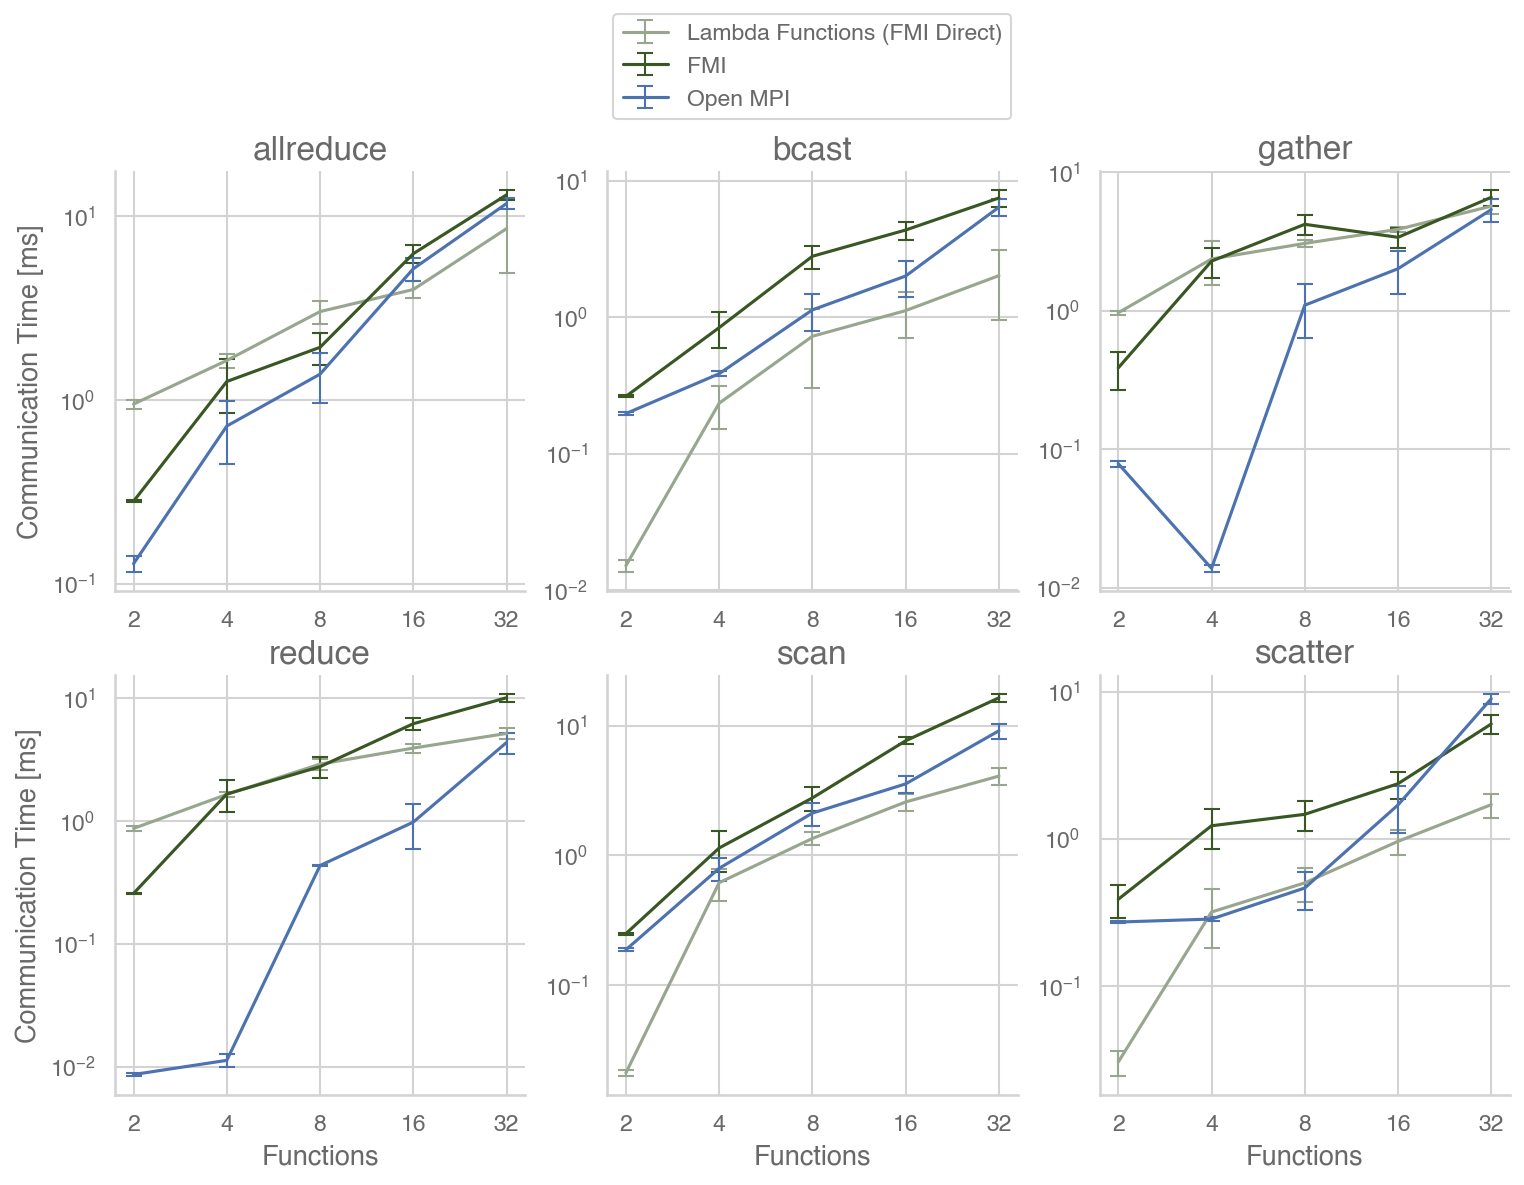

In [123]:
NUM_NODES = [2, 4, 8, 16, 32]
vals = {}
#for experiment in experiments:
#    vals[experiment] = pd.concat([mpi_bench[experiment][(mpi_bench[experiment]["method"] == "FMI") | (mpi_bench[experiment]["method"] == "Open MPI")], lambda_bench[experiment][lambda_bench[experiment]["method"] == "Direct"]])
#    vals[experiment]["method"] = vals[experiment]["method"].replace({"FMI": "EC2 VMs (FMI Direct)", "Open MPI": "EC2 VMs (Open MPI)", "Direct": "Lambda Functions (FMI Direct)"})
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
#my_pal = {
#    "EC2 VMs (FMI Direct)": "#385723", 
#    "Lambda Functions (FMI Direct)": "#98a68f", 
#    "EC2 VMs (Open MPI)": "b"
#}
my_pal = {
    "FMI": "#385723", 
    "Lambda Functions (FMI Direct)": "#98a68f", 
    "Open MPI": "b"
}

full_data = pd.concat([mpi_data, tcp_data])

#for method in ["EC2 VMs (FMI Direct)", "Lambda Functions (FMI Direct)", "EC2 VMs (Open MPI)"]:
for method in ["Lambda Functions (FMI Direct)", "FMI", "Open MPI"]:
    ix, iy = 0, 0
    for experiment in experiments:
        plot_data = {}
        error = []
        preds = {}
        for num_node in NUM_NODES:
            experiment_sizes = {
                "allreduce": 4,
                "bcast": 4,
                "gather": 4992 / num_node,
                "reduce": 4,
                "scan": 4,
                "scatter": 4992 / num_node
            }
            #values = vals[experiment].loc[(vals[experiment]['n'] == num_node) & (vals[experiment]['method'] == method)]['latency']
            values = full_data.loc[
                (full_data['experiment'] == experiment) & (full_data['ranks'] == num_node)
                & (full_data['method'] == method)
            ]['duration']
            mean = np.mean(values)
            #mean = np.median(values)
            ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
            plot_data[num_node] = mean / 1000
            #print(mean, ci)
            error.append(ci / 1000)
            
            
        axs[ix,iy].errorbar(plot_data.keys(), plot_data.values(), error, elinewidth=1, capsize=4, label=method, c=my_pal[method])
        axs[ix,iy].set_title(experiment)
        axs[ix,iy].set_yscale('log')
        axs[ix,iy].set_xscale('log')
        axs[ix,iy].set_xticks(NUM_NODES)
        axs[ix,iy].set_xticklabels(NUM_NODES)
        if ix == 0 and iy == 1:
            axs[ix,iy].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), fancybox=True)
        else:
            axs[ix,iy].legend([],[], frameon=False)
        if ix == 1:
            axs[ix,iy].set_xlabel("Functions")
        else:
            axs[ix,iy].set_xlabel(None)
        if iy == 0:
            axs[ix,iy].set_ylabel("Communication Time [ms]")
        else:
            axs[ix,iy].set_ylabel(None)
        iy += 1
        if iy > 2:
            iy = 0
            ix = 1
#fig.savefig(os.path.join(OUTPUT_PATH, "fmi_mpi_lambda_benchmark_comparison.pdf"), bbox_inches='tight')

## New new data

In [171]:
MPI_BASE_BATH = os.path.join(BASE_PATH, 'mpi', 'new_res_spread')
SMI_BASE_BATH = os.path.join(BASE_PATH, 'fmi_vms', 'new_res_spread')
NUM_NODES = [2, 4, 8, 16, 32]
experiments = ['allreduce', 'bcast', 'gather', 'reduce', 'scan', 'scatter']

In [172]:
MPI_BASE_BATH = os.path.join(BASE_PATH, 'mpi', 'new_res_spread')
SMI_BASE_BATH = os.path.join(BASE_PATH, 'fmi_vms', 'new_res_spread')
NUM_NODES = [2, 4, 8, 16, 32]
experiments = ['allreduce', 'bcast', 'gather', 'reduce', 'scan', 'scatter']
mpi_data = []

for experiment in experiments:
    for num_node in NUM_NODES:
        
        dfs = []
        for rank in range(num_node):
                          
            mpi_path = os.path.join(MPI_BASE_BATH, f"{experiment}_{num_node}_{rank}.out")
            
            data = pd.read_csv(mpi_path, names=['start', 'end', 'duration'])[1:101]
            data.reset_index(inplace=True)
            dfs.append(data)
            #data['size'] = num_node
            #data['ranks'] = num_node
            #data['experiment'] = experiment
            #print(data)
        data = pd.concat(dfs)
        #print(data)
        max_data = data.groupby(['index'])['duration'].max().reset_index()
        max_data['ranks'] = num_node
        max_data['experiment'] = experiment
        #print(max_data)
        mpi_data.append(max_data)
        
mpi_data = pd.concat(mpi_data)
mpi_data["method"] = "Open MPI"

fmi_data = []

for experiment in experiments:
    for num_node in NUM_NODES:
        
        dfs = []
        for rank in range(num_node):
                          
            fmi_path = os.path.join(SMI_BASE_BATH, f"{experiment}_{num_node}_{rank}.out")
            
            data = pd.read_csv(fmi_path, names=['start', 'end', 'duration'])[1:101]
            data.reset_index(inplace=True)
            dfs.append(data)
            #data['size'] = num_node
            #data['ranks'] = num_node
            #data['experiment'] = experiment
            #print(data)
        data = pd.concat(dfs)
        #print(data)
        max_data = data.groupby(['index'])['duration'].max().reset_index()
        max_data['ranks'] = num_node
        max_data['experiment'] = experiment
        ##print(max_data)
        #print(max_data.min())
        #print(max_data.mean())
        #print(max_data.median())
        #print(max_data.quantile(.95))
        #print(max_data.quantile(.99))
        #print(max_data.max())
        fmi_data.append(max_data)
        
fmi_data = pd.concat(fmi_data)
fmi_data["method"] = "FMI"
mpi_data = pd.concat([fmi_data, mpi_data])
data = mpi_data

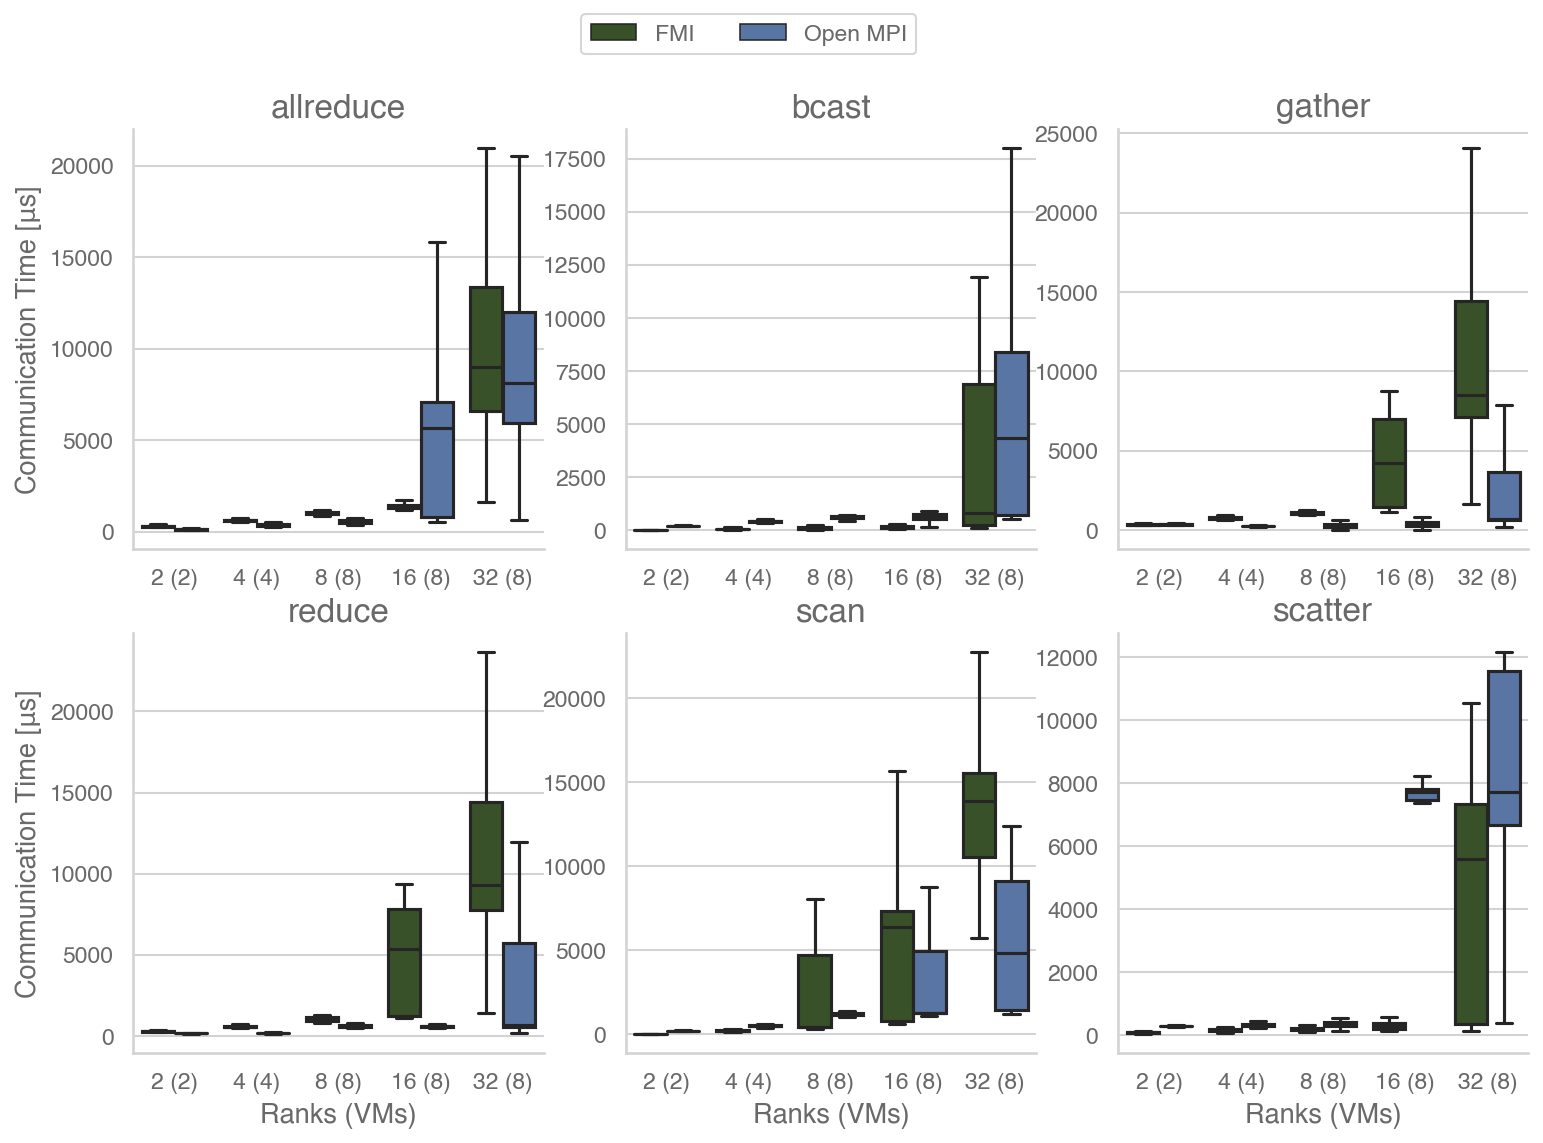

In [174]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
my_pal = {"Open MPI": "b", "FMI": "#385723"}
#axs[0,0].set_ylim(0,4000)
axs[0,0].set_title("allreduce")
#axs[0,1].set_ylim(0,4000)
axs[0,1].set_title("bcast")
#axs[0,2].set_ylim(0,4000)
axs[0,2].set_title("gather")
#axs[1,0].set_ylim(0,4000)
axs[1,0].set_title("reduce")
#axs[1,1].set_ylim(0,4000)
axs[1,1].set_title("scan")
#axs[1,2].set_ylim(0,4000)
axs[1,2].set_title("scatter")

sns.boxplot(x="ranks", y="duration", hue="method",
            data=data.loc[data['experiment'] == "allreduce"], ax=axs[0, 0], palette=my_pal,showfliers=False)
#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "allreduce"], ax=axs[0, 0], cut=0,palette=my_pal, scale="count")
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "bcast"], ax=axs[0, 1], palette=my_pal,showfliers=False)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "gather"], ax=axs[0, 2],palette=my_pal,showfliers=False)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "reduce"], ax=axs[1, 0], palette=my_pal,showfliers=False)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "scan"], ax=axs[1, 1], palette=my_pal,showfliers=False)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "scatter"], ax=axs[1, 2],  palette=my_pal,showfliers=False)


for ix,iy in np.ndindex(axs.shape):
    axs[ix,iy].set_xticklabels(["2 (2)", "4 (4)", "8 (8)", "16 (8)", "32 (8)"])
    if ix == 0 and iy == 1:
        axs[ix,iy].legend(loc='upper center', bbox_to_anchor=(0.3, 1.3), ncol=2, fancybox=True)
    else:
        axs[ix,iy].legend([],[], frameon=False)
    if ix == 1:
        axs[ix,iy].set_xlabel("Ranks (VMs)")
    else:
        axs[ix,iy].set_xlabel(None)
    if iy == 0:
        axs[ix,iy].set_ylabel("Communication Time [μs]")
    else:
        axs[ix,iy].set_ylabel(None)

#axs[0,0].text(2, 3750, va='center', ha='center', size='x-small',
#      backgroundcolor="white", color=my_pal["FMI"],
#      s=data.loc[(data['experiment'] == "allreduce") & (data["ranks"] == 8) & (data["method"] == "FMI")]["duration"].median())


Text(2, 3750, 'nan')

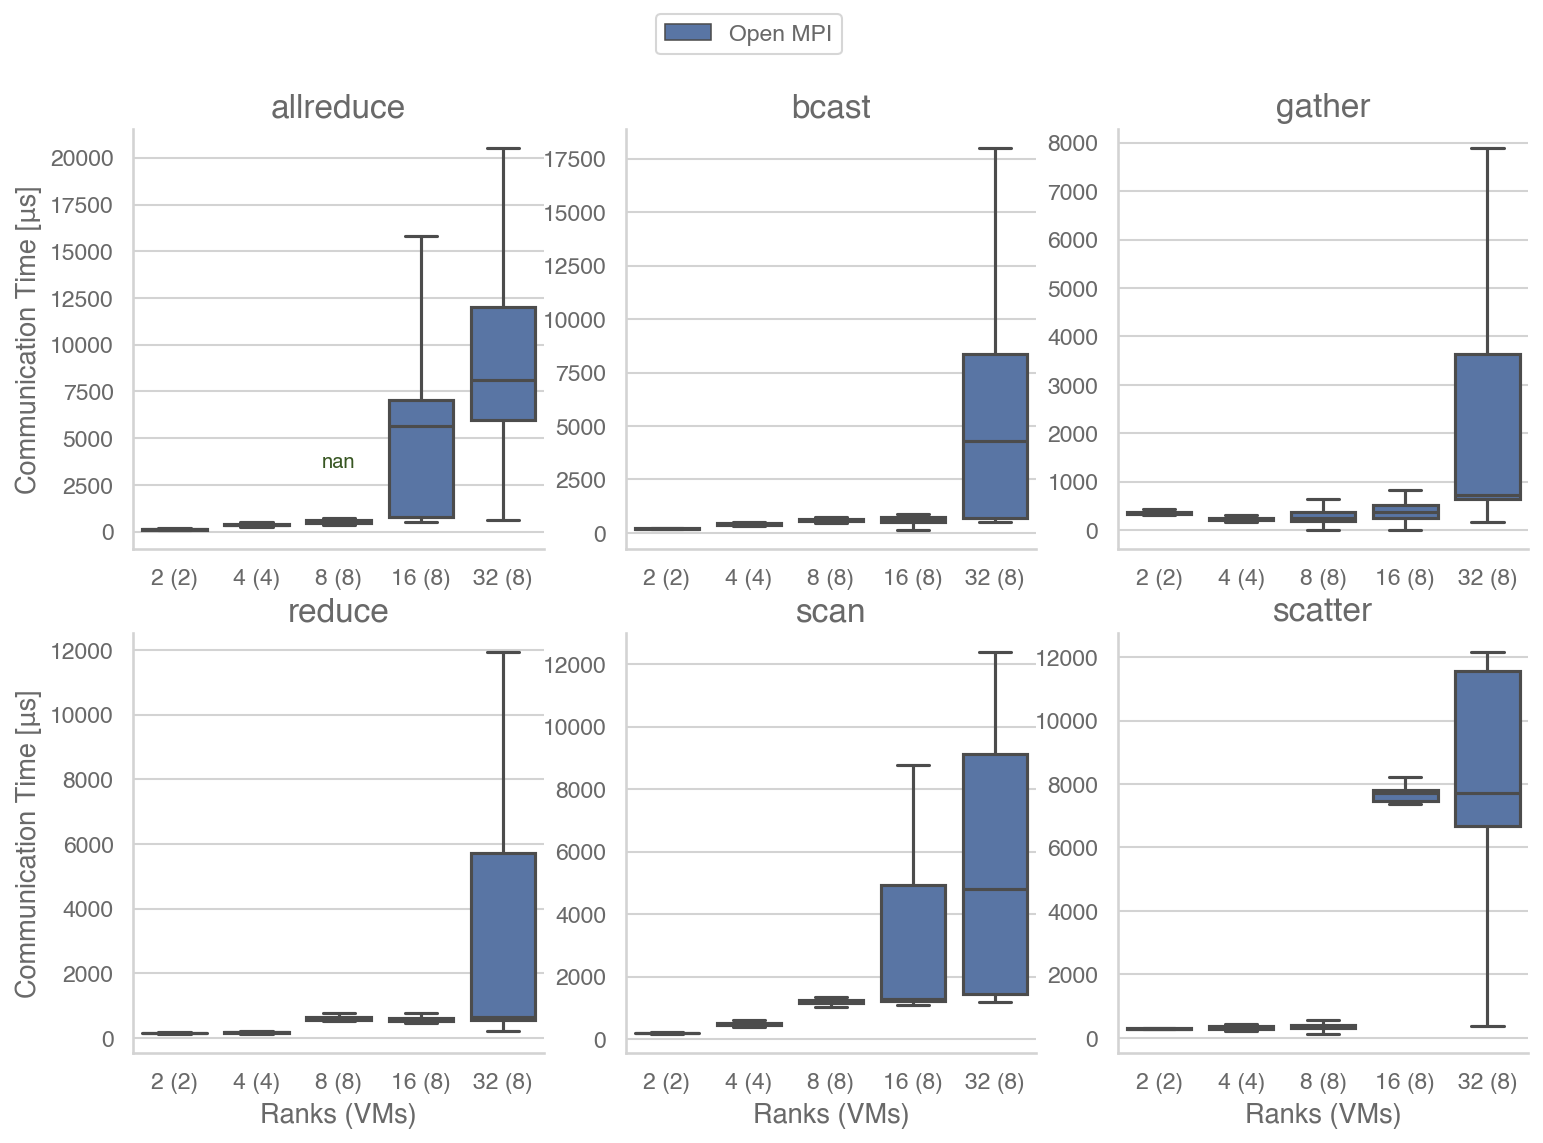

In [135]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
my_pal = {"Open MPI": "b", "FMI": "#385723"}
#axs[0,0].set_ylim(0,4000)
axs[0,0].set_title("allreduce")
#axs[0,1].set_ylim(0,4000)
axs[0,1].set_title("bcast")
#axs[0,2].set_ylim(0,4000)
axs[0,2].set_title("gather")
#axs[1,0].set_ylim(0,4000)
axs[1,0].set_title("reduce")
#axs[1,1].set_ylim(0,4000)
axs[1,1].set_title("scan")
#axs[1,2].set_ylim(0,4000)
axs[1,2].set_title("scatter")

sns.boxplot(x="ranks", y="duration", hue="method",
            data=data.loc[data['experiment'] == "allreduce"], ax=axs[0, 0], palette=my_pal,showfliers=False)
#sns.violinplot(x="ranks", y="duration", hue="method",
#               data=data.loc[data['experiment'] == "allreduce"], ax=axs[0, 0], cut=0,palette=my_pal, scale="count")
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "bcast"], ax=axs[0, 1], palette=my_pal,showfliers=False)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "gather"], ax=axs[0, 2],palette=my_pal,showfliers=False)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "reduce"], ax=axs[1, 0], palette=my_pal,showfliers=False)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "scan"], ax=axs[1, 1], palette=my_pal,showfliers=False)
sns.boxplot(x="ranks", y="duration", hue="method",
               data=data.loc[data['experiment'] == "scatter"], ax=axs[1, 2],  palette=my_pal,showfliers=False)


for ix,iy in np.ndindex(axs.shape):
    axs[ix,iy].set_xticklabels(["2 (2)", "4 (4)", "8 (8)", "16 (8)", "32 (8)"])
    if ix == 0 and iy == 1:
        axs[ix,iy].legend(loc='upper center', bbox_to_anchor=(0.3, 1.3), ncol=2, fancybox=True)
    else:
        axs[ix,iy].legend([],[], frameon=False)
    if ix == 1:
        axs[ix,iy].set_xlabel("Ranks (VMs)")
    else:
        axs[ix,iy].set_xlabel(None)
    if iy == 0:
        axs[ix,iy].set_ylabel("Communication Time [μs]")
    else:
        axs[ix,iy].set_ylabel(None)

axs[0,0].text(2, 3750, va='center', ha='center', size='x-small',
      backgroundcolor="white", color=my_pal["FMI"],
      s=data.loc[(data['experiment'] == "allreduce") & (data["ranks"] == 8) & (data["method"] == "FMI")]["duration"].median())


In [161]:
MPI_BASE_BATH = os.path.join(BASE_PATH, 'mpi', 'new_res')
SMI_BASE_BATH = os.path.join(BASE_PATH, 'fmi_vms', 'new_res')
NUM_NODES = [2, 4, 8, 16, 32]
experiments = ['allreduce', 'bcast', 'gather', 'reduce', 'scan', 'scatter']
mpi_data = []

for experiment in experiments:
    for num_node in NUM_NODES:
        
        dfs = []
        for rank in range(num_node):
                          
            mpi_path = os.path.join(MPI_BASE_BATH, f"{experiment}_{num_node}_{rank}.out")
            
            data = pd.read_csv(mpi_path, names=['start', 'end', 'duration'])[1:101]
            data.reset_index(inplace=True)
            dfs.append(data)
            #data['size'] = num_node
            #data['ranks'] = num_node
            #data['experiment'] = experiment
            #print(data)
        data = pd.concat(dfs)
        #print(data)
        max_data = data.groupby(['index'])['duration'].max().reset_index()
        max_data['ranks'] = num_node
        max_data['experiment'] = experiment
        #print(max_data)
        mpi_data.append(max_data)
        
mpi_data = pd.concat(mpi_data)
mpi_data["method"] = "Open MPI (EC2 VMs)"

fmi_data = []

for experiment in experiments:
    for num_node in NUM_NODES:
        
        dfs = []
        for rank in range(num_node):
                          
            fmi_path = os.path.join(SMI_BASE_BATH, f"{experiment}_{num_node}_{rank}.out")
            
            data = pd.read_csv(fmi_path, names=['start', 'end', 'duration'])[1:101]
            data.reset_index(inplace=True)
            dfs.append(data)
            #data['size'] = num_node
            #data['ranks'] = num_node
            #data['experiment'] = experiment
            #print(data)
        data = pd.concat(dfs)
        #print(data)
        max_data = data.groupby(['index'])['duration'].max().reset_index()
        max_data['ranks'] = num_node
        max_data['experiment'] = experiment
        ##print(max_data)
        #print(max_data.min())
        #print(max_data.mean())
        #print(max_data.median())
        #print(max_data.quantile(.95))
        #print(max_data.quantile(.99))
        #print(max_data.max())
        fmi_data.append(max_data)
        
fmi_data = pd.concat(fmi_data)
fmi_data["method"] = "FMI (EC2 VMs)"
mpi_data = pd.concat([fmi_data, mpi_data])
data = mpi_data

In [164]:

BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIRECT_BASE_PATH = os.path.join(BASE_PATH, 'fmi', 'out_tcp')
REDIS_BASE_BATH = os.path.join(BASE_PATH, 'fmi', 'out_redis')
S3_BASE_BATH = os.path.join(BASE_PATH, 'fmi', 'out_s3')
experiments = ['allreduce', 'bcast', 'gather', 'reduce', 'scan', 'scatter']

NUM_NODES = [2, 4, 8, 16, 32]


tcp_data = []
for experiment in experiments:
    for num_node in NUM_NODES:
        
        dfs = []
        for rank in range(num_node):
                          
            for rep in range(30):
                mpi_path = os.path.join(DIRECT_BASE_PATH, f"{experiment}_{num_node}_{rank}_{rep+1}.json")
                #print(mpi_path)
                data = pd.read_csv(mpi_path, names=['peer', 'idx', 'start', 'end', 'duration', 'retries'])[1:]
                data['idx'] = rep
                data.reset_index(inplace=True)
                dfs.append(data)
            #data['size'] = num_node
            #data['ranks'] = num_node
            #data['experiment'] = experiment
            #print(data)
        data = pd.concat(dfs)
        #print(data)
        #print(data)
        max_data = data.groupby(['idx'])['duration'].max().reset_index()
        max_data['ranks'] = num_node
        max_data['experiment'] = experiment
        #print(max_data)
        tcp_data.append(max_data)
        
tcp_data = pd.concat(tcp_data)
tcp_data["method"] = "FMI (Lambda Functions)"

#ata = pd.concat([s3_data, redis_data, tcp_data])


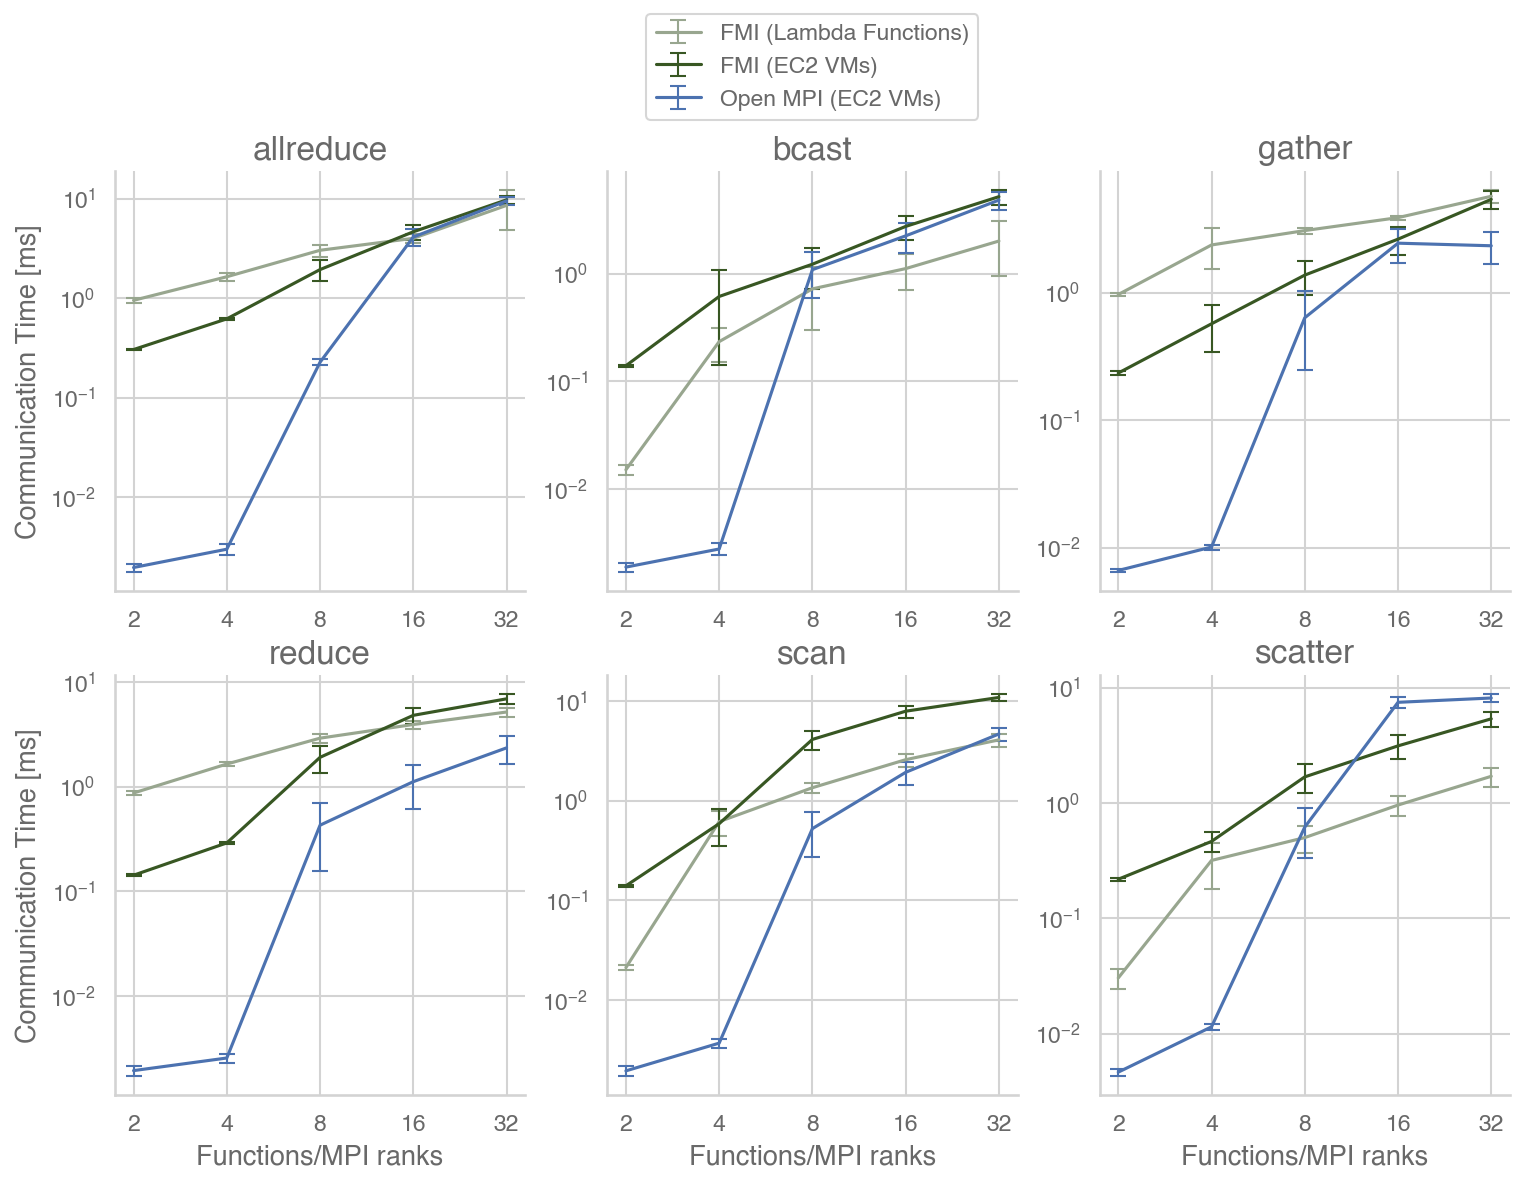

In [166]:
NUM_NODES = [2, 4, 8, 16, 32]
vals = {}
#for experiment in experiments:
#    vals[experiment] = pd.concat([mpi_bench[experiment][(mpi_bench[experiment]["method"] == "FMI") | (mpi_bench[experiment]["method"] == "Open MPI")], lambda_bench[experiment][lambda_bench[experiment]["method"] == "Direct"]])
#    vals[experiment]["method"] = vals[experiment]["method"].replace({"FMI": "EC2 VMs (FMI Direct)", "Open MPI": "EC2 VMs (Open MPI)", "Direct": "Lambda Functions (FMI Direct)"})
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
#my_pal = {
#    "EC2 VMs (FMI Direct)": "#385723", 
#    "Lambda Functions (FMI Direct)": "#98a68f", 
#    "EC2 VMs (Open MPI)": "b"
#}
my_pal = {
    "FMI (EC2 VMs)": "#385723", 
    "FMI (Lambda Functions)": "#98a68f", 
    "Open MPI (EC2 VMs)": "b"
}

full_data = pd.concat([mpi_data, tcp_data])

#for method in ["EC2 VMs (FMI Direct)", "Lambda Functions (FMI Direct)", "EC2 VMs (Open MPI)"]:
for method in ["FMI (Lambda Functions)", "FMI (EC2 VMs)", "Open MPI (EC2 VMs)"]:
    ix, iy = 0, 0
    for experiment in experiments:
        plot_data = {}
        error = []
        preds = {}
        for num_node in NUM_NODES:
            experiment_sizes = {
                "allreduce": 4,
                "bcast": 4,
                "gather": 4992 / num_node,
                "reduce": 4,
                "scan": 4,
                "scatter": 4992 / num_node
            }
            #values = vals[experiment].loc[(vals[experiment]['n'] == num_node) & (vals[experiment]['method'] == method)]['latency']
            values = full_data.loc[
                (full_data['experiment'] == experiment) & (full_data['ranks'] == num_node)
                & (full_data['method'] == method)
            ]['duration']
            mean = np.mean(values)
            #mean = np.median(values)
            ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
            plot_data[num_node] = mean / 1000
            #print(mean, ci)
            error.append(ci / 1000)
            
            
        axs[ix,iy].errorbar(plot_data.keys(), plot_data.values(), error, elinewidth=1, capsize=4, label=method, c=my_pal[method])
        axs[ix,iy].set_title(experiment)
        axs[ix,iy].set_yscale('log')
        axs[ix,iy].set_xscale('log')
        axs[ix,iy].set_xticks(NUM_NODES)
        axs[ix,iy].set_xticklabels(NUM_NODES)
        if ix == 0 and iy == 1:
            axs[ix,iy].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), fancybox=True)
        else:
            axs[ix,iy].legend([],[], frameon=False)
        if ix == 1:
            axs[ix,iy].set_xlabel("Functions/MPI ranks")
        else:
            axs[ix,iy].set_xlabel(None)
        if iy == 0:
            axs[ix,iy].set_ylabel("Communication Time [ms]")
        else:
            axs[ix,iy].set_ylabel(None)
        iy += 1
        if iy > 2:
            iy = 0
            ix = 1
#fig.savefig(os.path.join(OUTPUT_PATH, "fmi_mpi_lambda_benchmark_comparison.pdf"), bbox_inches='tight')